In [46]:
import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

## Autocorrelation and decomposition of the data

Goal: find if there are trends and seasonality in the data.

In [2]:
df = wr.get_clean_data(start2018=True)
sdf = s.get_summary_df(df)

In [3]:
ts_df = round(df.purchase_amount.resample('D').sum(), 2)
ts_sdf = round(sdf.purchase_amount.resample('D').sum(), 2)

In [4]:
len(ts_sdf) == len(ts_df)

True

In [5]:
(ts_df == ts_sdf).sum() == len(ts_sdf)

True

Just confirmed that Time Series from original data frame and summary data frame are the same.

In [6]:
del ts_df
del ts_sdf

In [7]:
train, test = wr.split_data(sdf)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

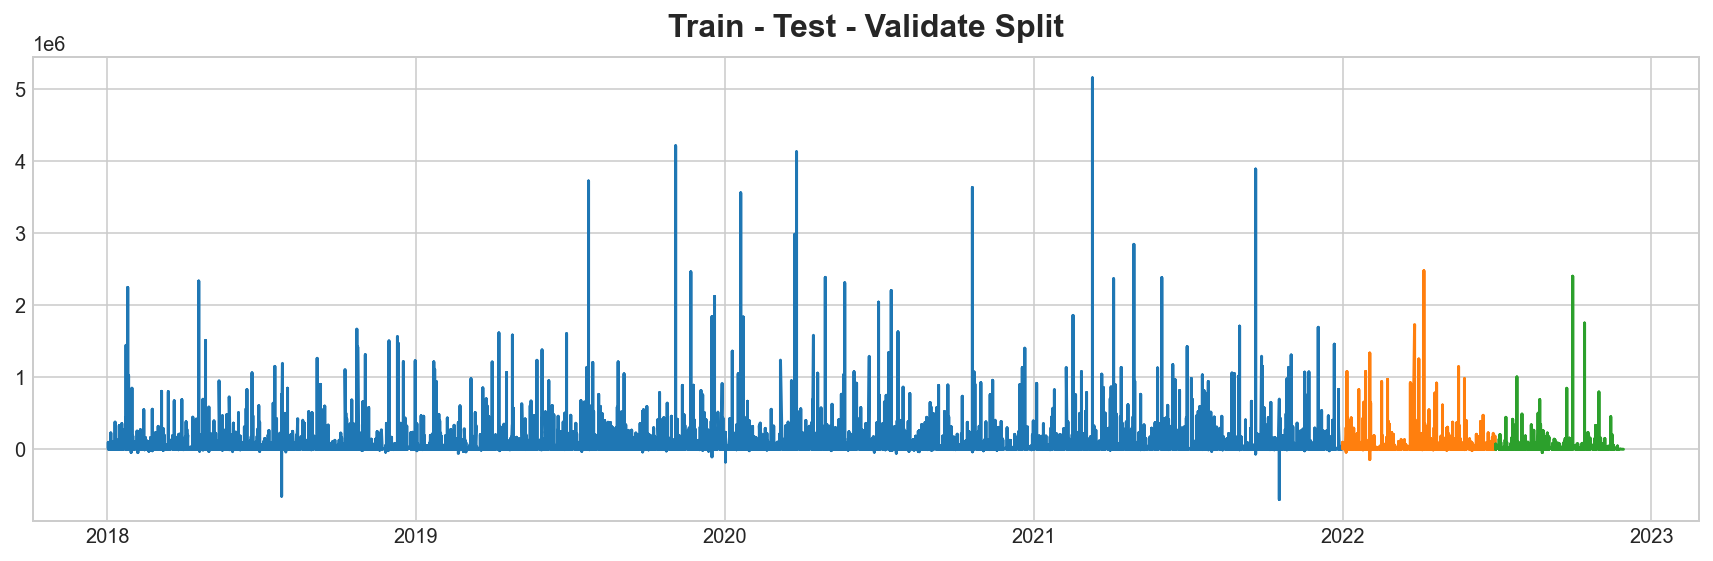

In [48]:
plt.plot(train.index, train.purchase_amount)
plt.plot(validate.index, validate.purchase_amount)
plt.plot(test.index, test.purchase_amount)
plt.title('Train - Test - Validate Split')
plt.show()

In [9]:
ts = train.purchase_amount.copy()

In [10]:
ts.resample('D').sum().head(1)

order_date
2018-01-02   171,192.78
Freq: D, Name: purchase_amount, dtype: float64

In [11]:
# total sales
ts.groupby([ts.index.year, ts.index.month]).sum().unstack(0)

order_date          2018          2019          2020          2021
order_date                                                        
1          16,930,827.33 17,500,114.78 20,919,149.59 13,755,277.58
2          10,092,852.40 10,377,192.33 11,404,678.09 14,321,416.82
3          12,607,705.04 13,918,330.83 29,069,657.71 25,802,374.74
4          20,420,085.28 20,700,005.40 27,196,176.56 36,552,117.39
5          17,649,493.55 18,175,050.59 18,412,469.91 16,405,310.53
6          17,408,497.96 19,287,732.67 22,491,557.66 25,678,835.83
7          21,675,251.34 32,358,415.99 32,811,974.92 30,644,761.69
8          15,045,363.83 23,237,611.62 16,961,381.59 22,255,931.07
9          12,057,172.55 15,645,412.18 18,431,995.06 26,389,174.48
10         20,374,873.23 16,836,763.12 21,958,282.47 26,324,734.16
11         15,363,321.17 21,002,931.90 14,161,302.82 16,530,068.38
12         18,979,726.63 24,378,521.54 17,163,472.38 18,394,819.27

In [12]:
ts.groupby([ts.index.year, ts.index.month]).mean().unstack(0)

order_date      2018      2019      2020      2021
order_date                                        
1          37,292.57 33,525.12 34,981.86 26,351.11
2          18,759.95 20,467.83 21,317.16 34,017.62
3          21,405.27 24,898.62 37,851.12 31,199.97
4          33,042.21 29,870.14 51,216.91 46,035.41
5          23,595.58 26,886.17 34,160.43 24,160.99
6          22,092.00 29,811.02 37,299.43 34,375.95
7          31,053.37 38,293.98 44,825.10 41,979.13
8          22,900.10 33,149.23 26,054.35 32,254.97
9          21,078.97 24,992.67 27,551.56 34,998.91
10         30,824.32 23,384.39 33,524.10 37,234.42
11         28,189.58 48,282.60 24,042.96 29,360.69
12         37,288.26 35,693.30 31,961.77 40,606.67

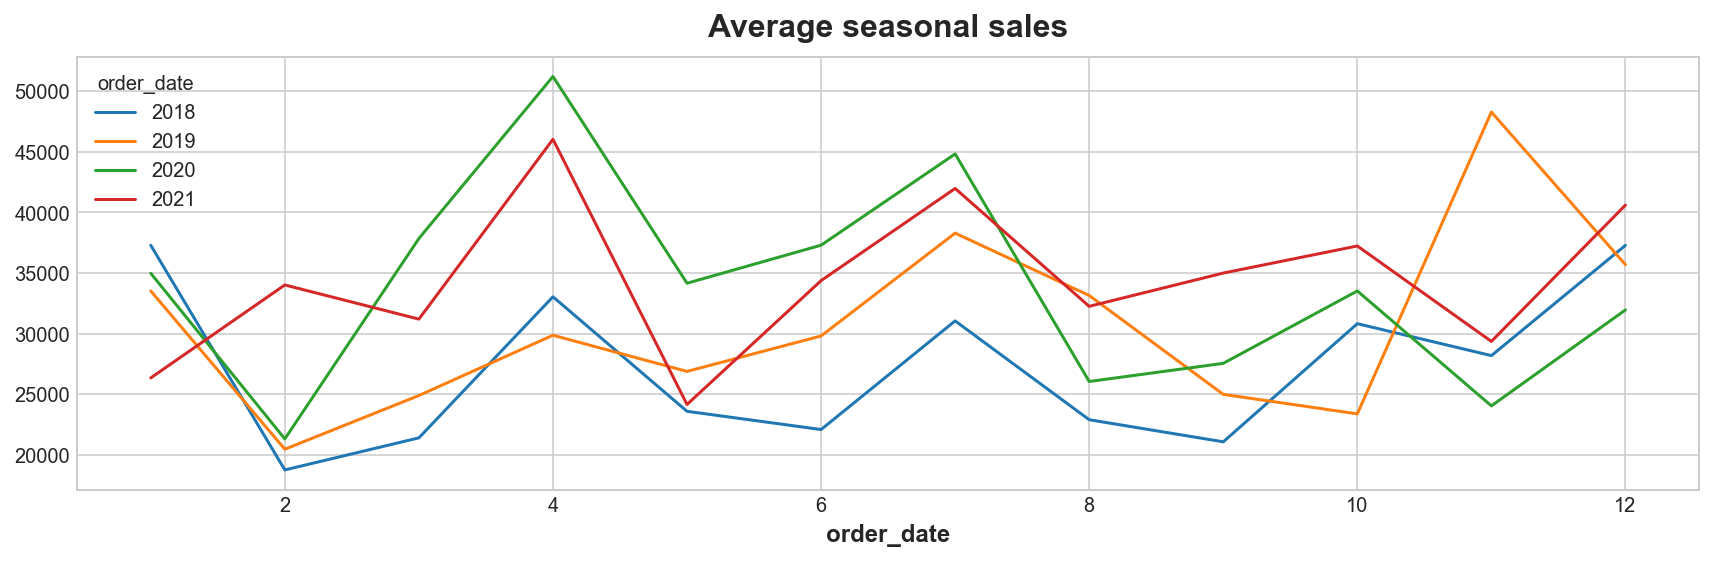

In [49]:
ts.groupby([ts.index.year, ts.index.month]).mean().unstack(0).plot()
plt.title('Average seasonal sales');

#### Average sales takeaways:
- Overall sales are higher in April and July. 
- We can see huge increase in sales in March-July 2020 where the pandemic began.
- Noramlly November is the month when average amount of sales decreases. In November 2019 there was a spike in average sales.
- Normaly in Fabruary average sales descrease. In February, 2021 average purchase amount was growing.

### Autocorrelation

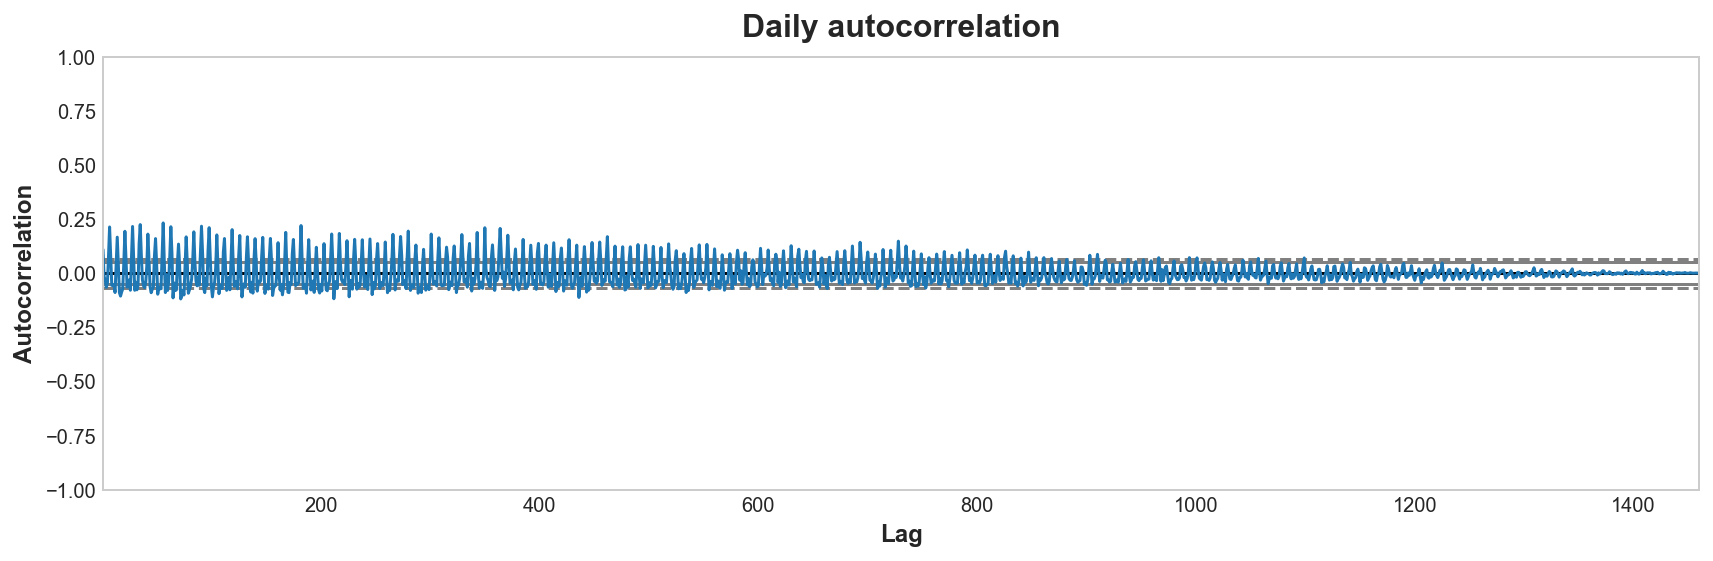

In [50]:
# daily
pd.plotting.autocorrelation_plot(ts.resample('D').sum())
plt.title('Daily autocorrelation');

Daily autocorrelation not significant

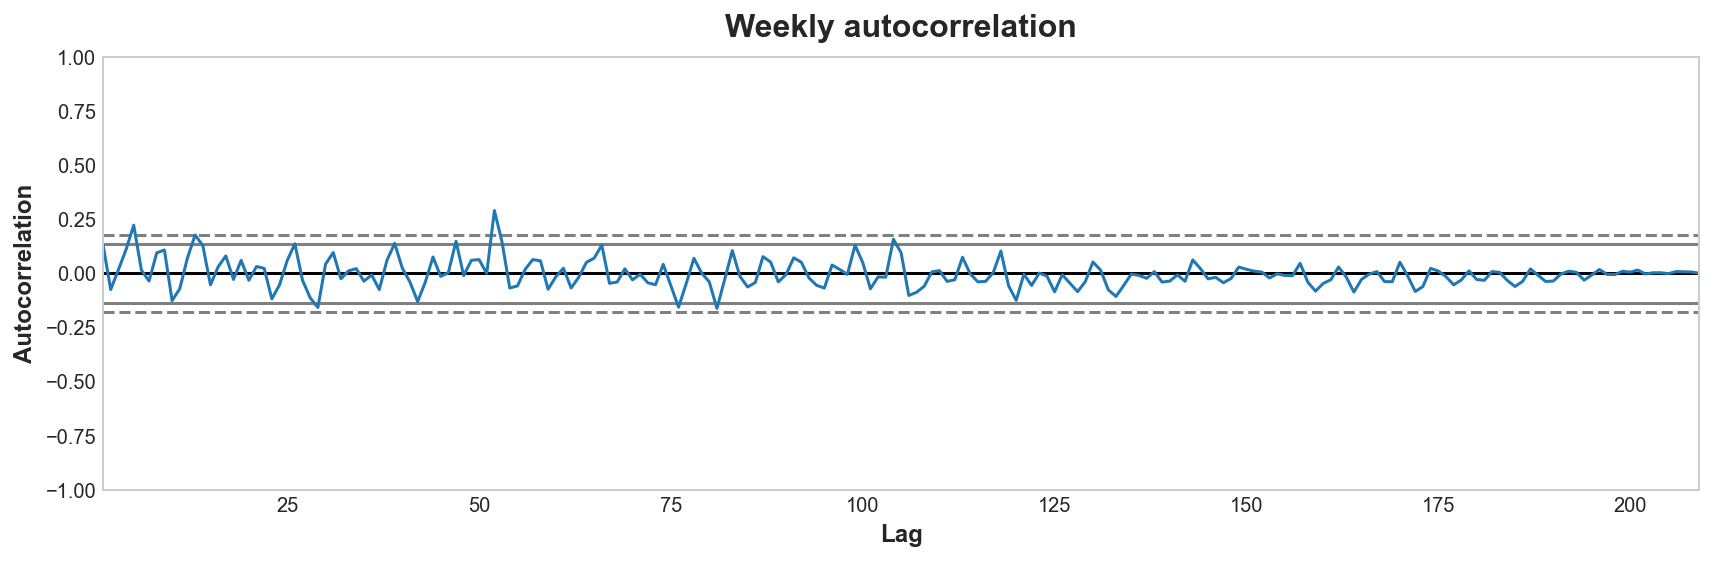

In [47]:
# weekly 
pd.plotting.autocorrelation_plot(ts.resample('W').sum())
plt.title('Weekly autocorrelation');

#### Weekly autocorrelation shows some significance on 52 weeks(1 year). 
- More or less copy-pasting the weekly results from the previous year into the next year may be one of the forecastin ways. Same we see below with the monthly autocorrelation. It peaks at 12 months

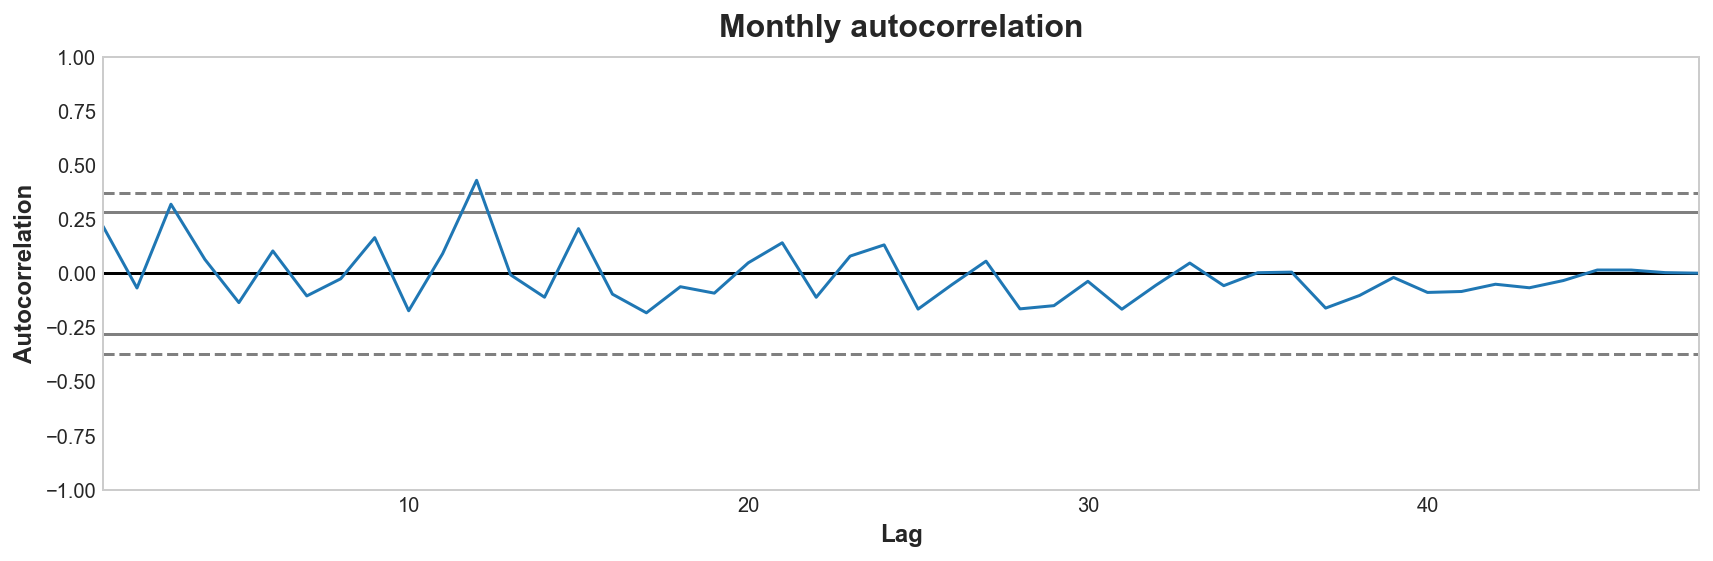

In [51]:
# monthly
pd.plotting.autocorrelation_plot(ts.resample('M').sum())
plt.title('Monthly autocorrelation');

There is almost no autocorrelation. Looks more like white noise

__Autocorrelation__ is the correlation between two observations at different points in a time series. For example, values that are separated by an interval might have a strong positive or negative correlation. When these correlations are present, they indicate that past values influence the current value.

In [17]:
y_daily = ts.resample('D').sum()

In [18]:
ts_df = y_daily.to_frame()

In [19]:
ts_df['lag_1'] = ts_df.purchase_amount.shift(1)

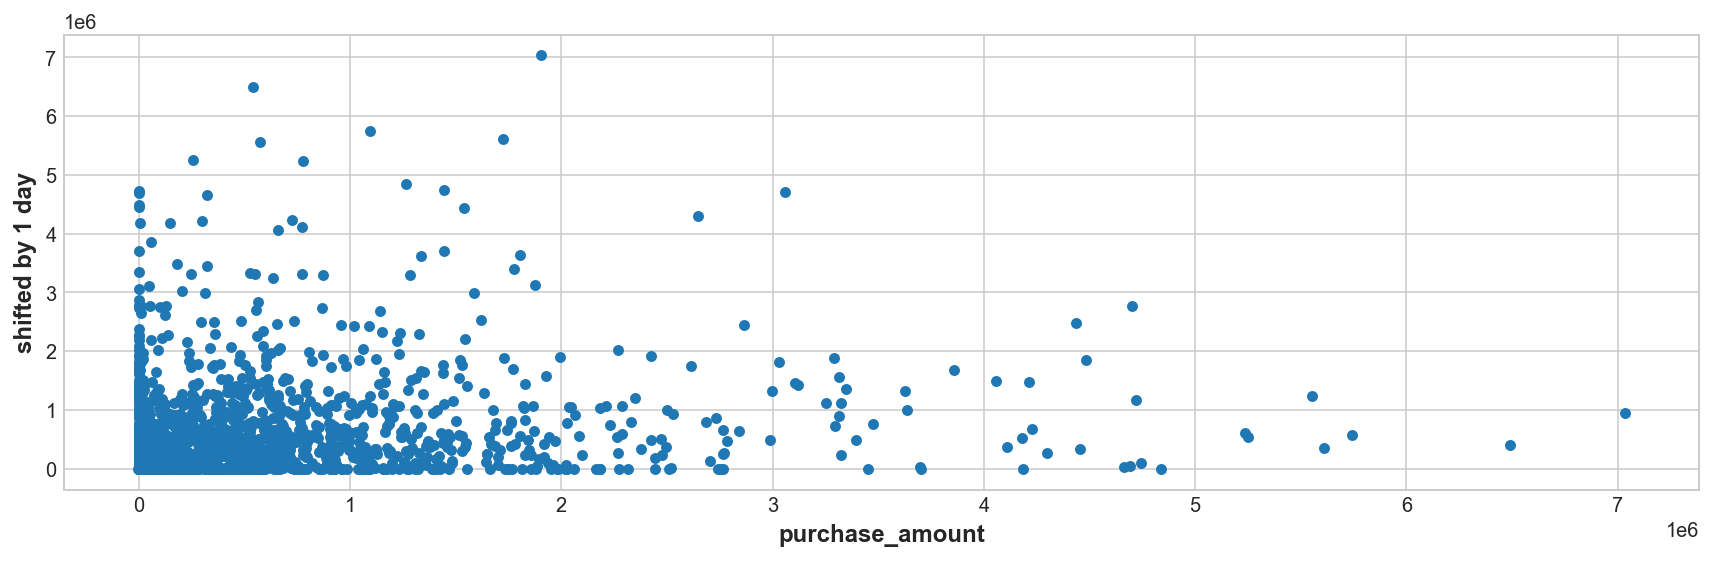

In [52]:
ax = ts_df.plot.scatter(x='purchase_amount', y='lag_1')
ax.set(xlabel='purchase_amount', ylabel='shifted by 1 day')
plt.show()

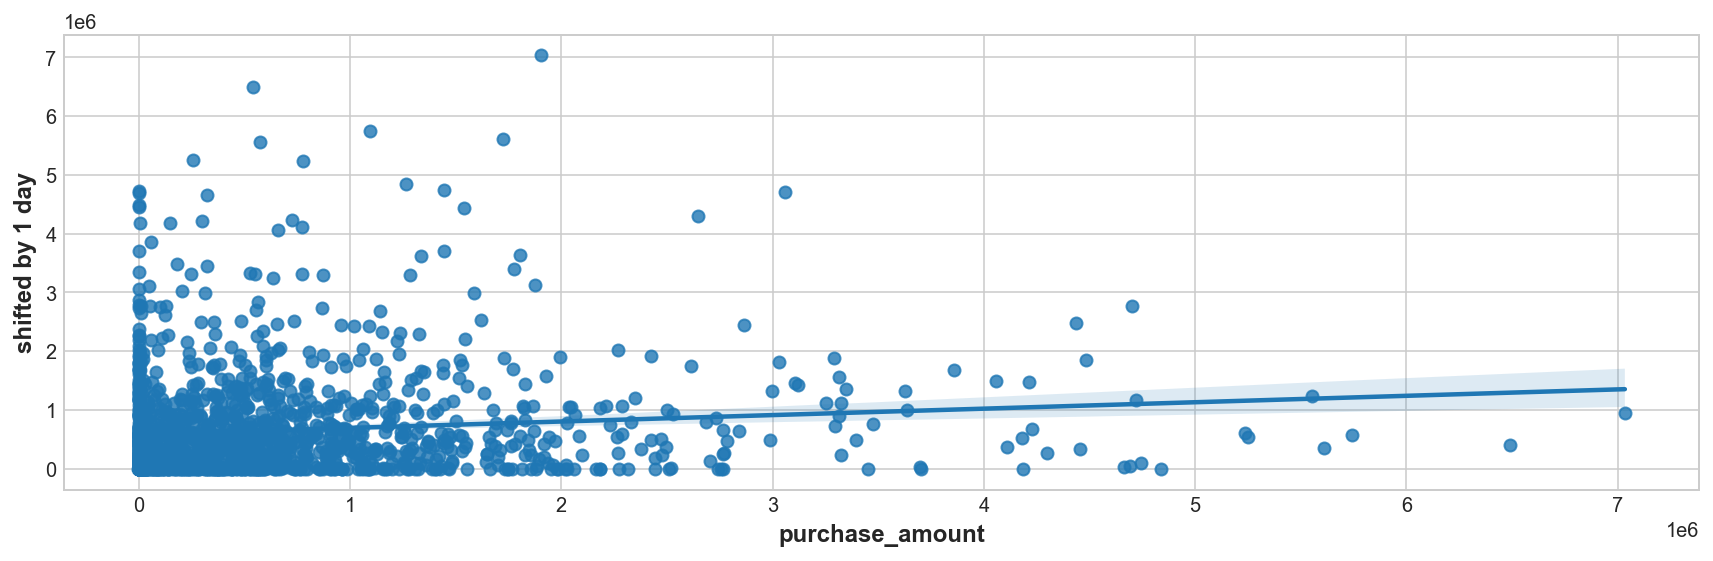

In [53]:
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_1')
ax.set(xlabel='purchase_amount', ylabel='shifted by 1 day')
plt.show()

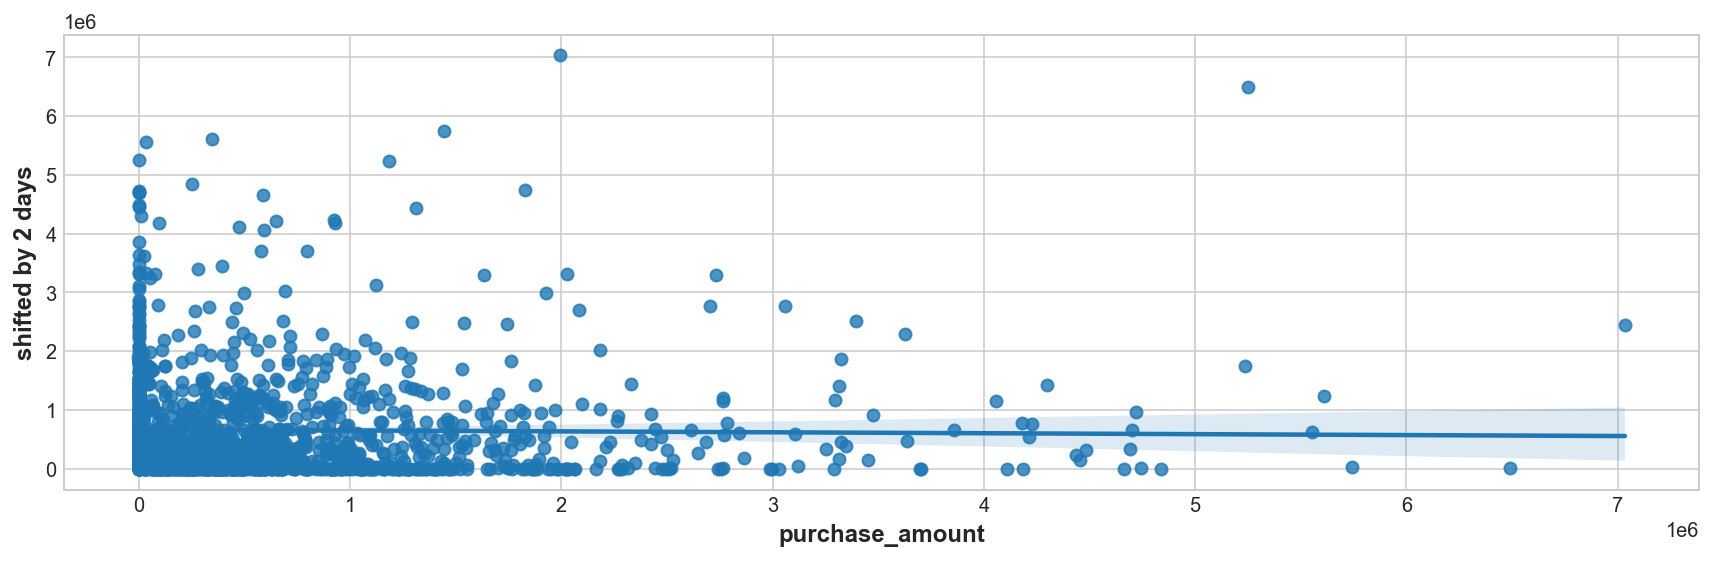

In [54]:
ts_df['lag_2'] = ts_df.purchase_amount.shift(2)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_2')
ax.set(xlabel='purchase_amount', ylabel='shifted by 2 days')
plt.show()

In [55]:
# less correlation with 2 days than with 1

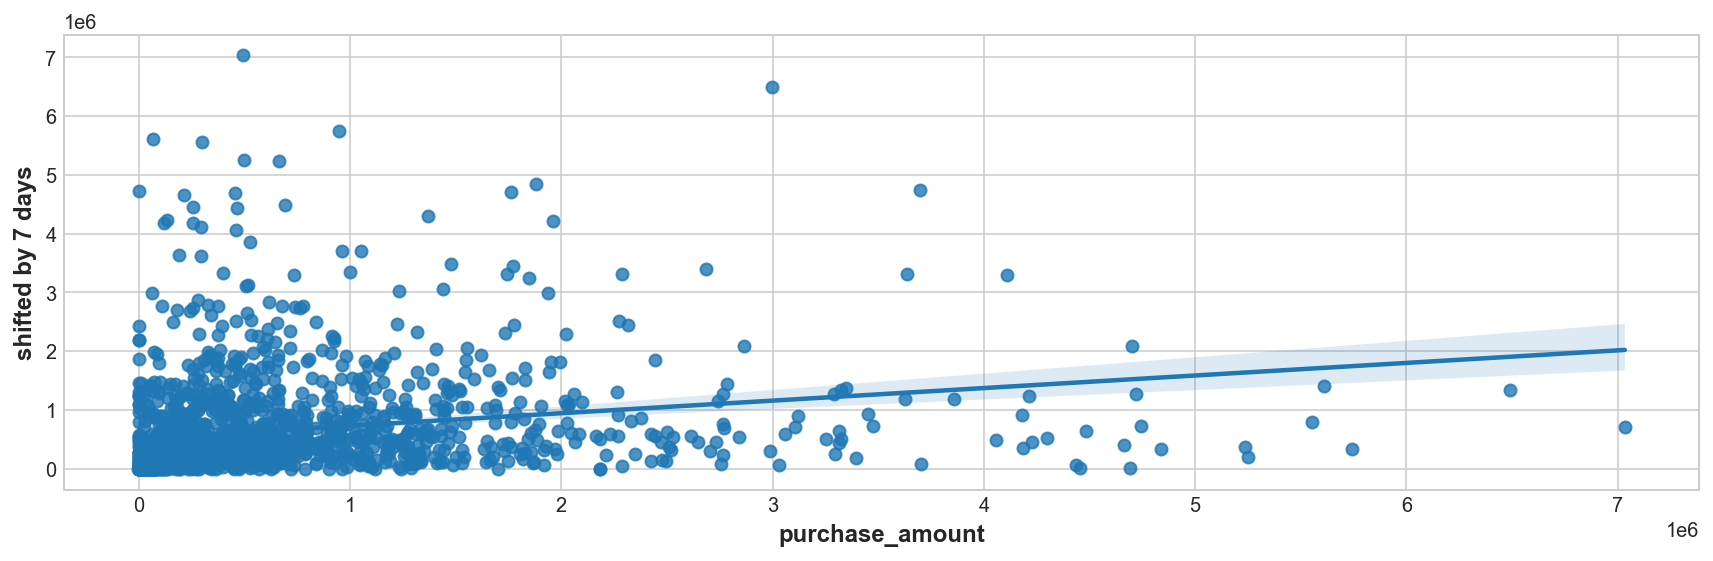

In [56]:
ts_df['lag_7'] = ts_df.purchase_amount.shift(7)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_7')
ax.set(xlabel='purchase_amount', ylabel='shifted by 7 days')
plt.show()

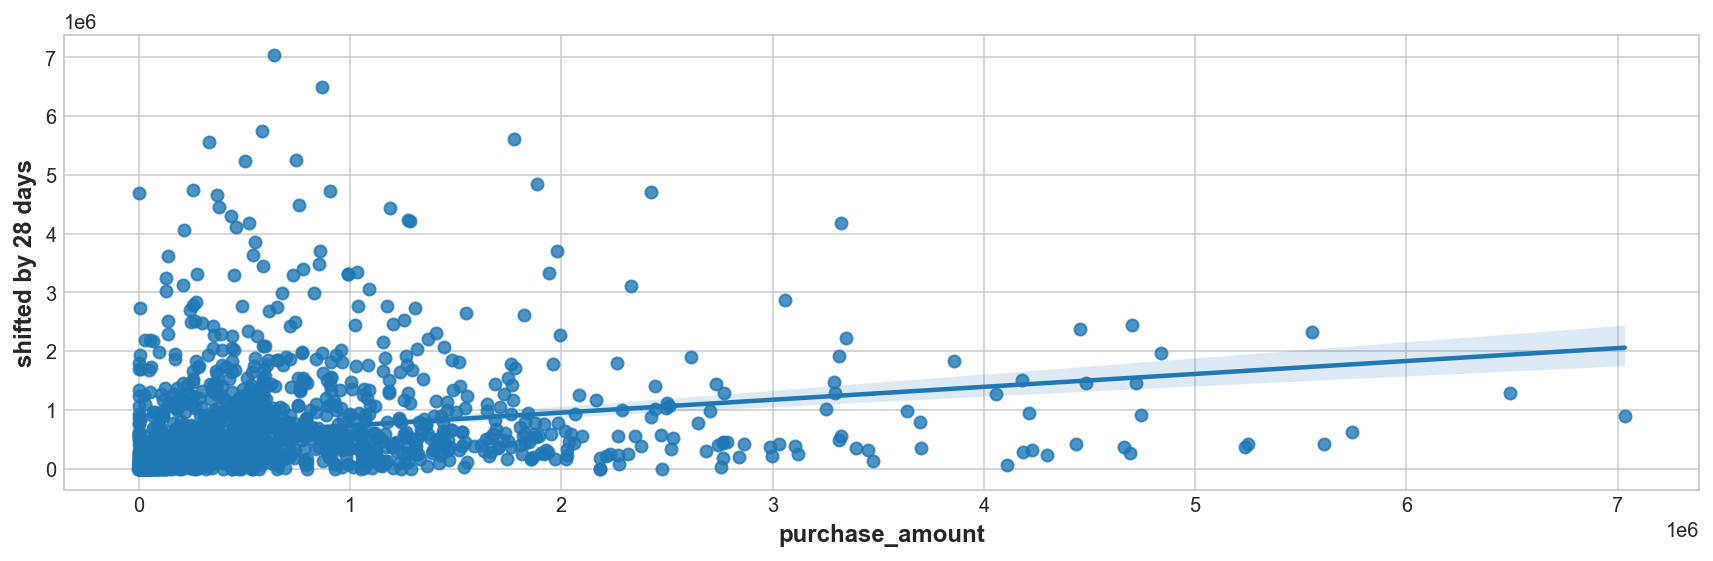

In [57]:
ts_df['lag_28'] = ts_df.purchase_amount.shift(28)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_28')
ax.set(xlabel='purchase_amount', ylabel='shifted by 28 days')
plt.show()

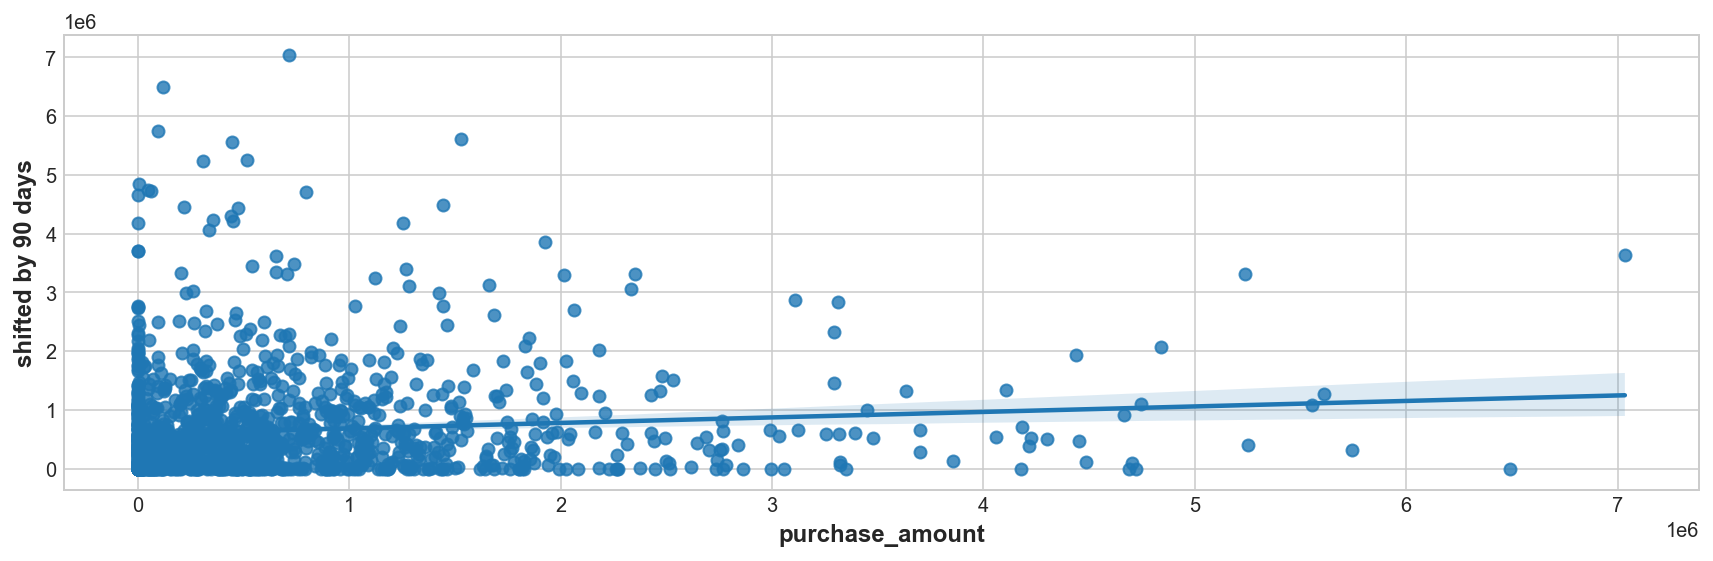

In [58]:
ts_df['lag_90'] = ts_df.purchase_amount.shift(90)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_90')
ax.set(xlabel='purchase_amount', ylabel='shifted by 90 days')
plt.show()

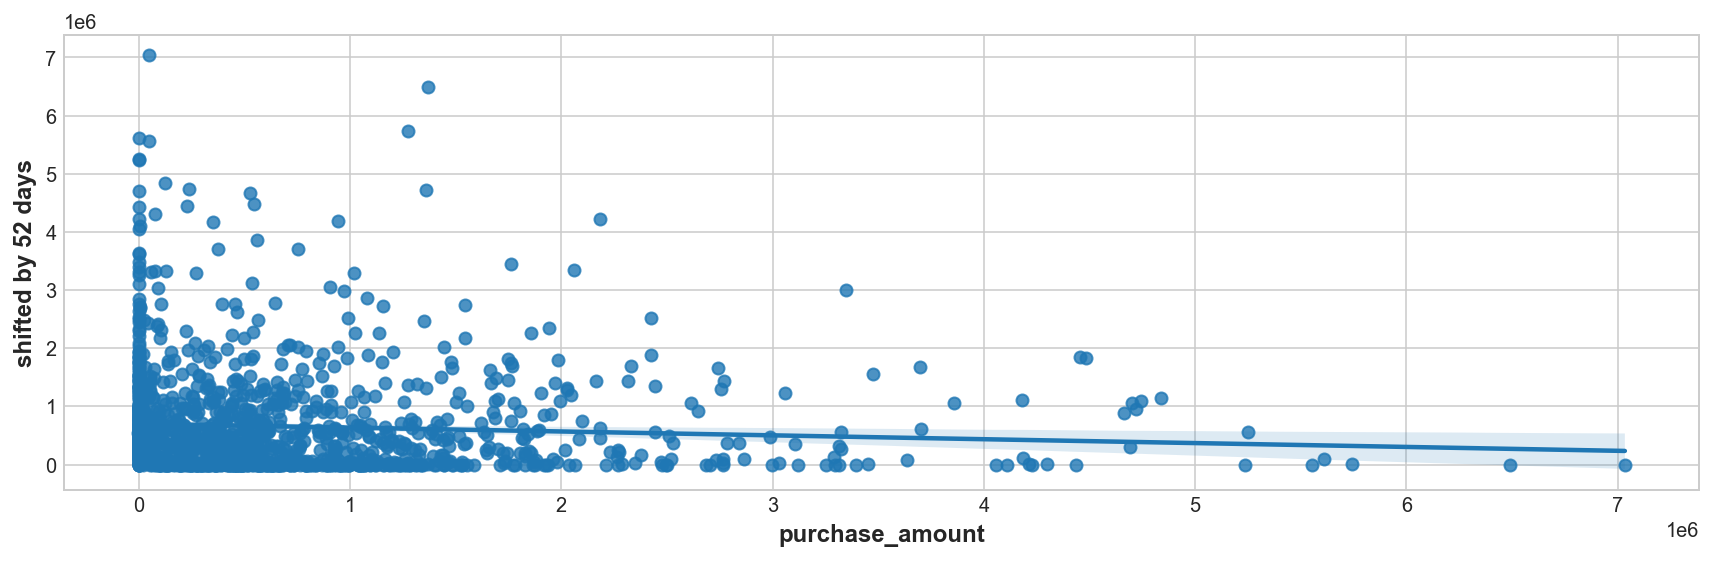

In [59]:
ts_df['lag_52'] = ts_df.purchase_amount.shift(52)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_52')
ax.set(xlabel='purchase_amount', ylabel='shifted by 52 days')
plt.show()

So far the strongest correlation seems to be with shifting by 28 days. Let's confirm if there is a linear relationship between lag values and purchase amount

In [60]:
stats.pearsonr(ts_df.purchase_amount, ts_df.lag_28.fillna(ts_df.lag_28.mean()))

(0.21729602149950036, 4.6085708100439404e-17)

#### Takeaway:
For building regression models we can use lag_28 values.

In [61]:
ts.head()

order_date
2018-01-02      252.00
2018-01-02    1,472.00
2018-01-02   15,981.12
2018-01-02   29,523.00
2018-01-02    8,008.00
Name: purchase_amount, dtype: float64

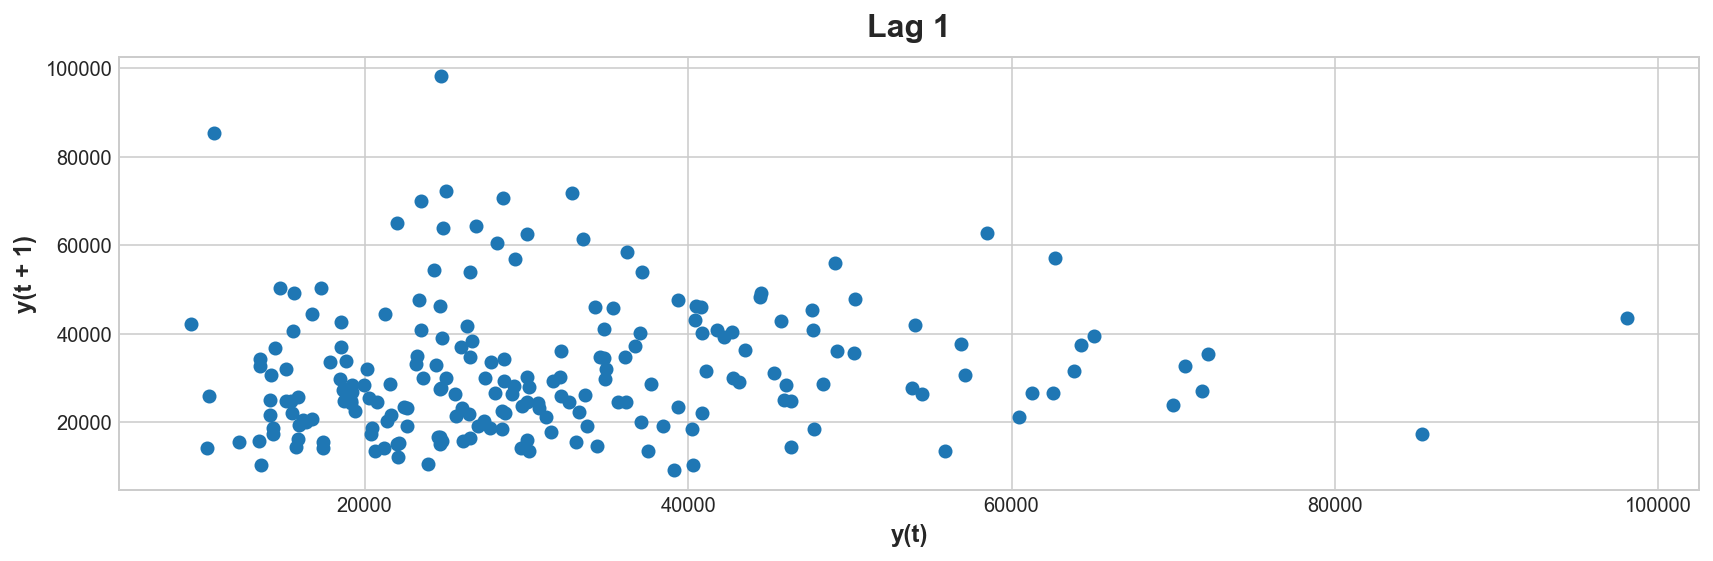

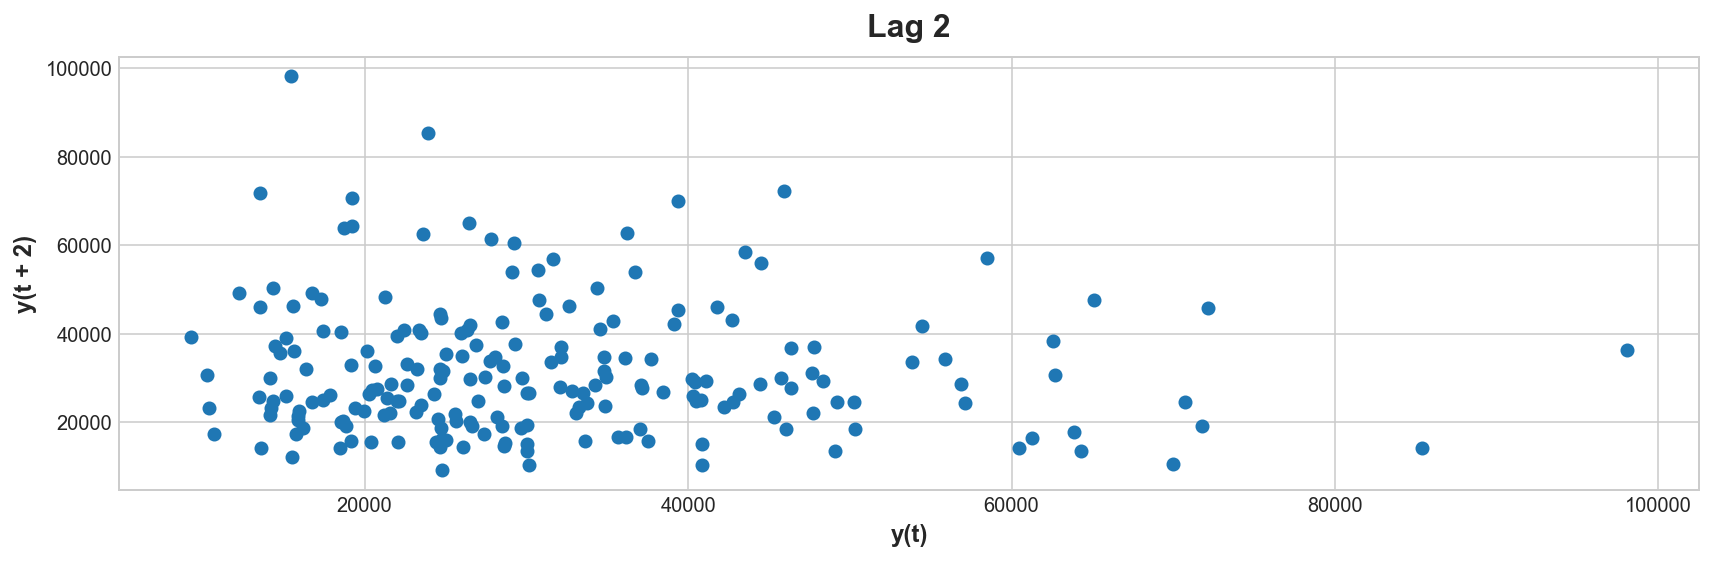

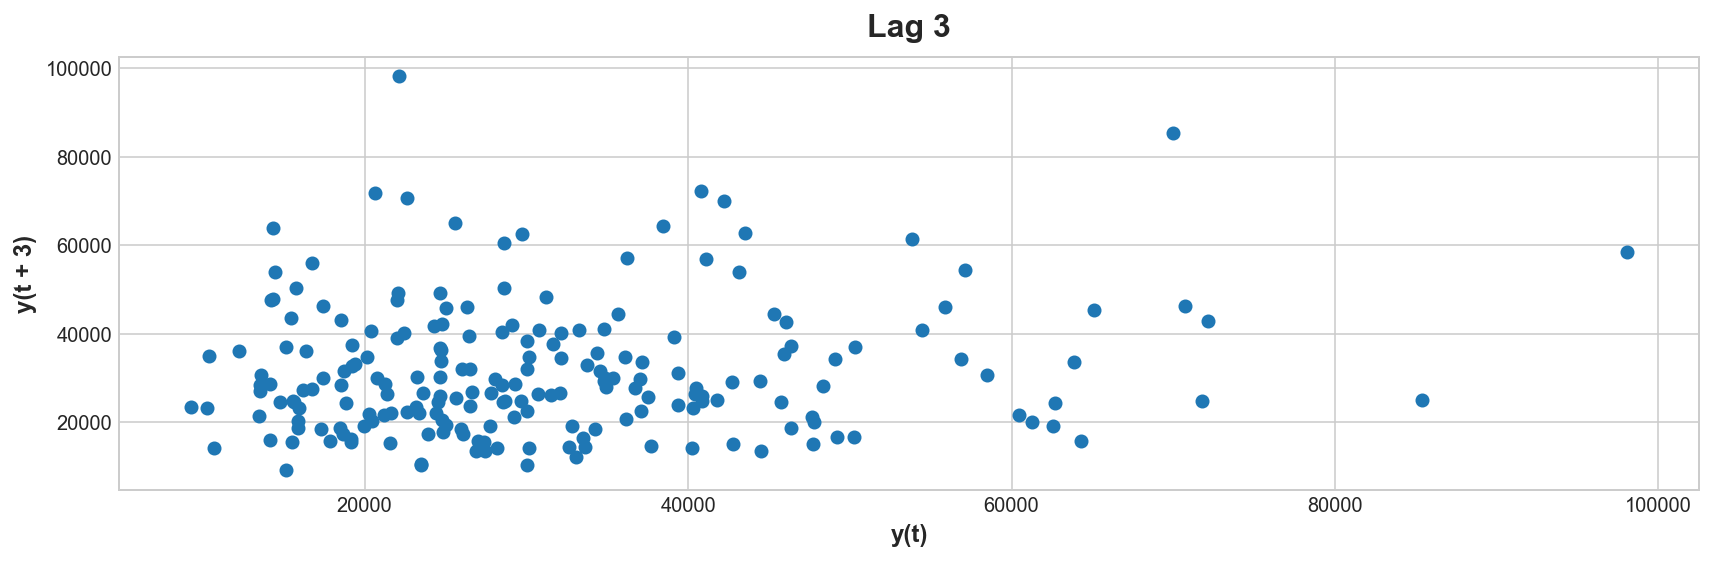

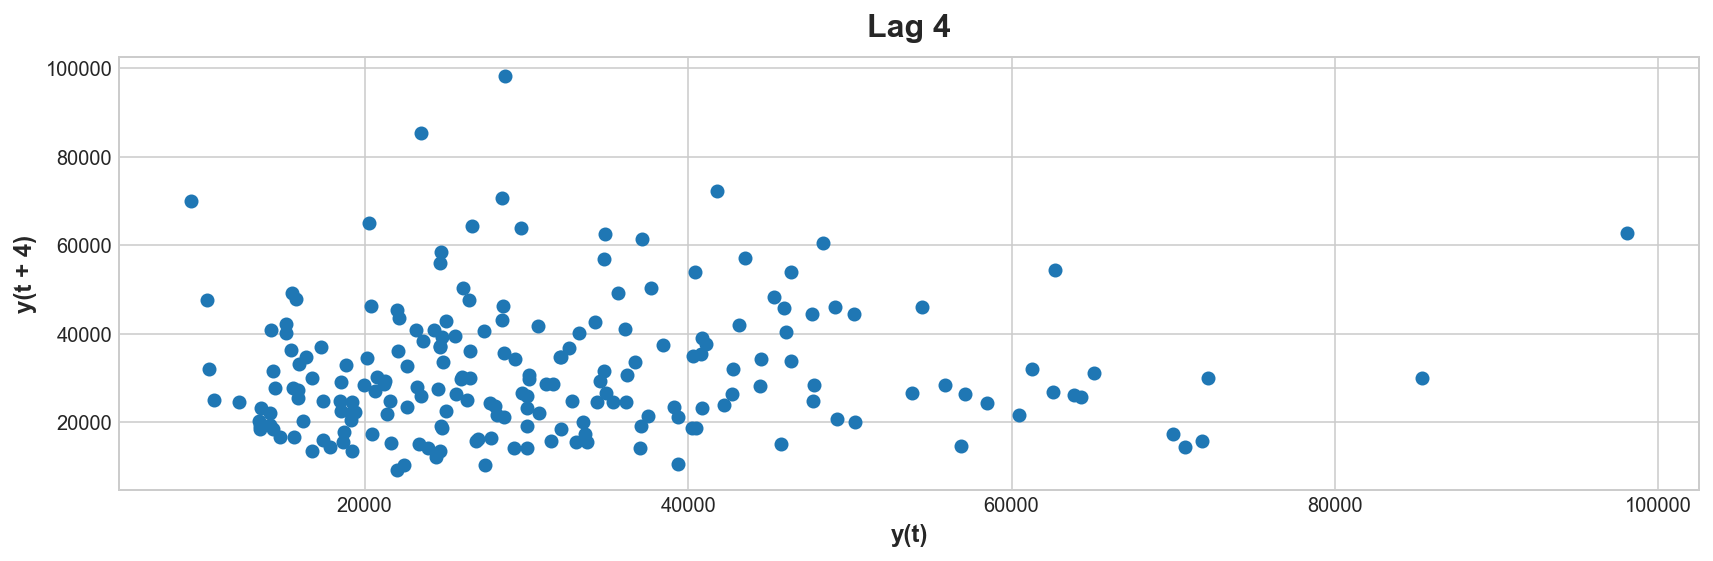

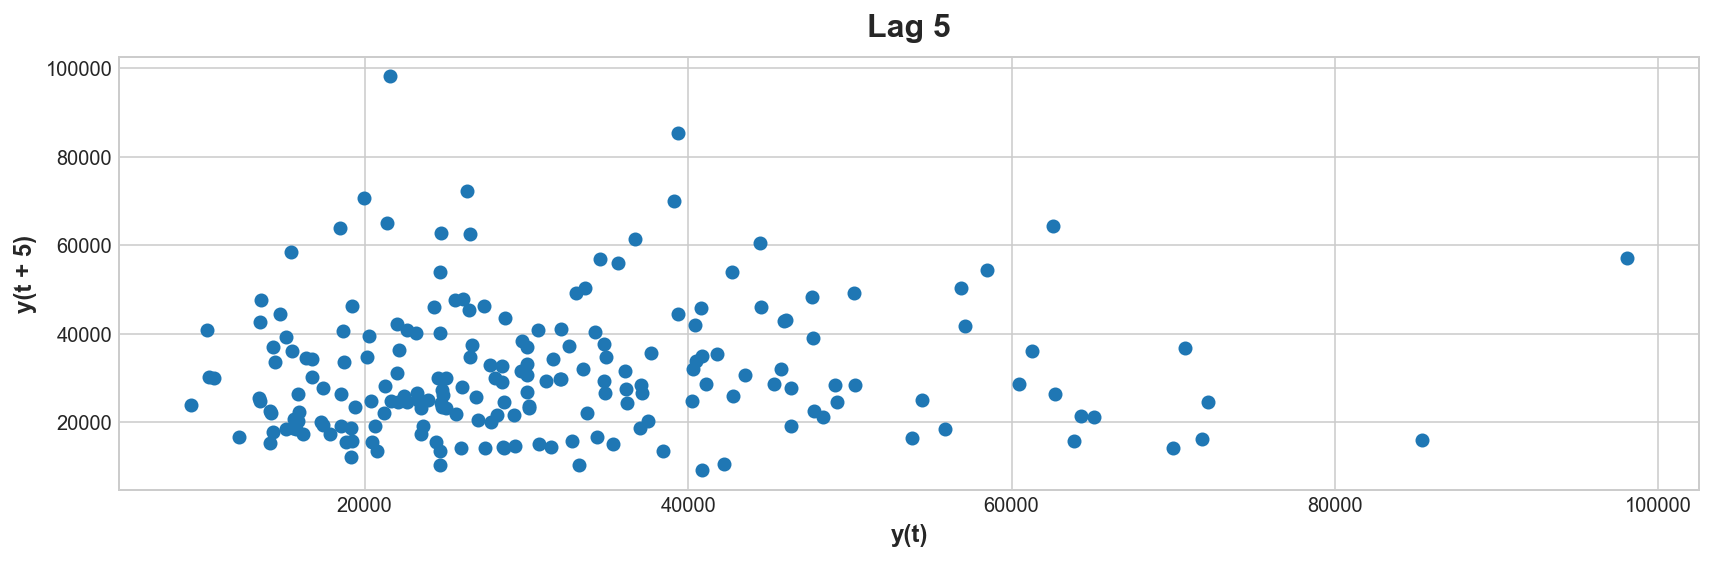

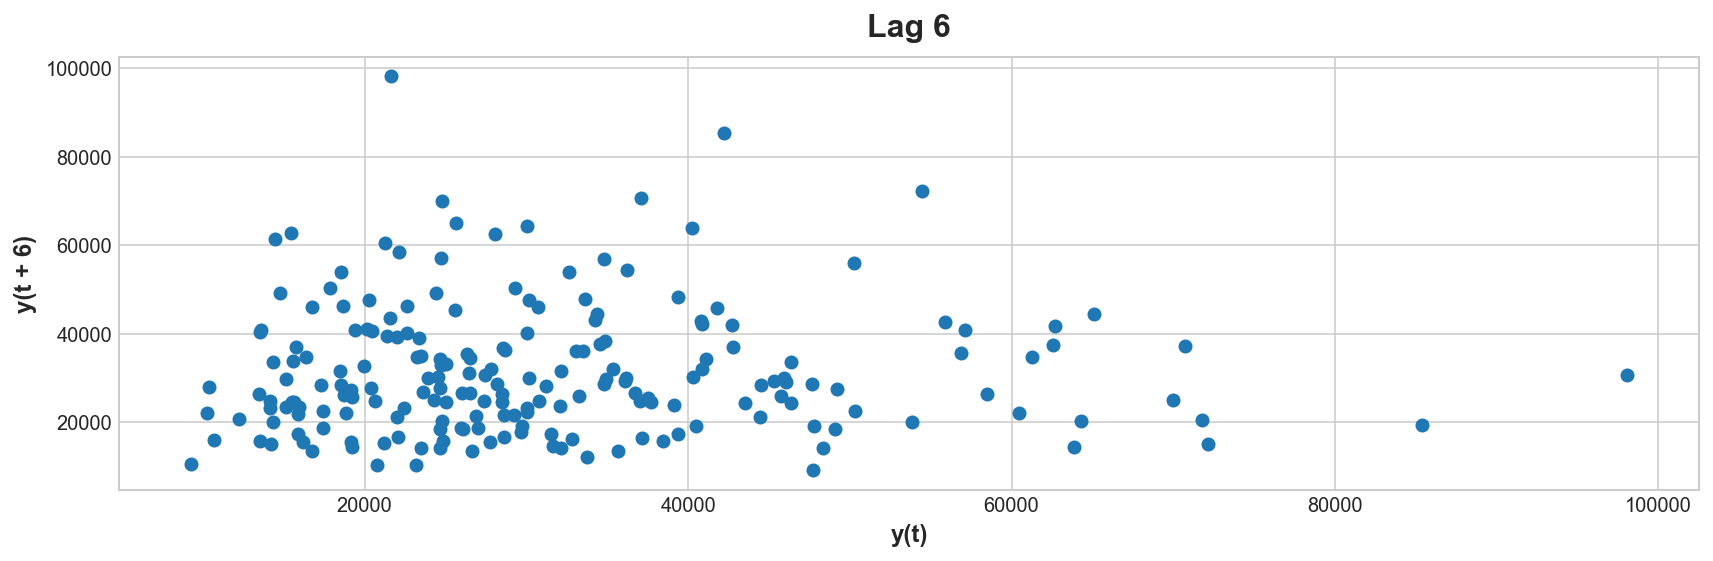

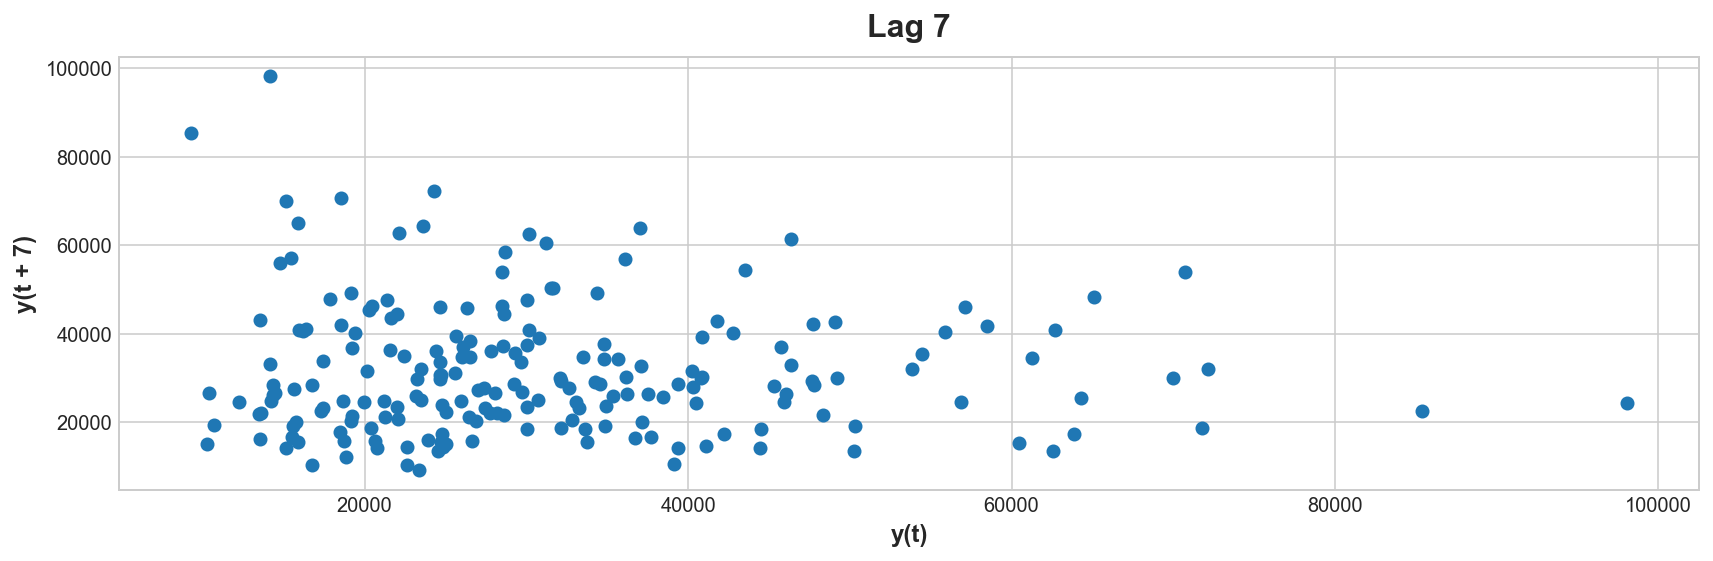

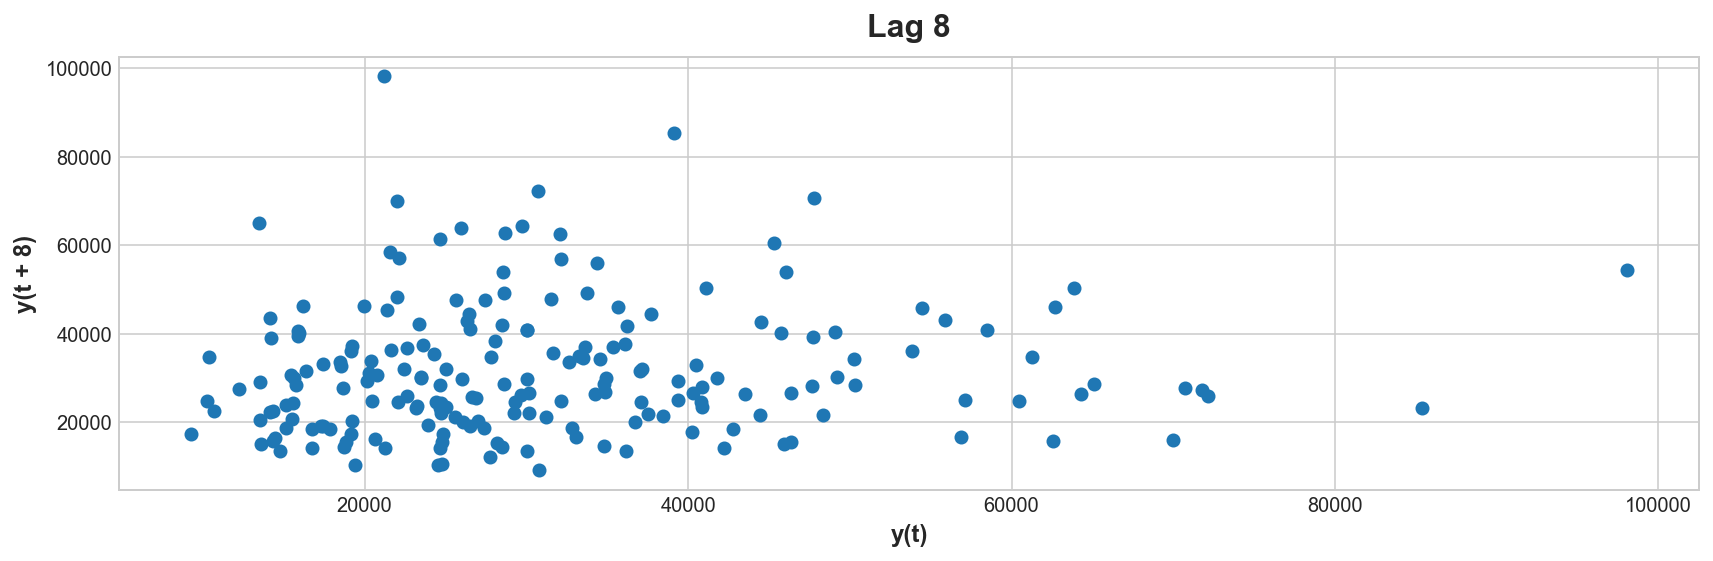

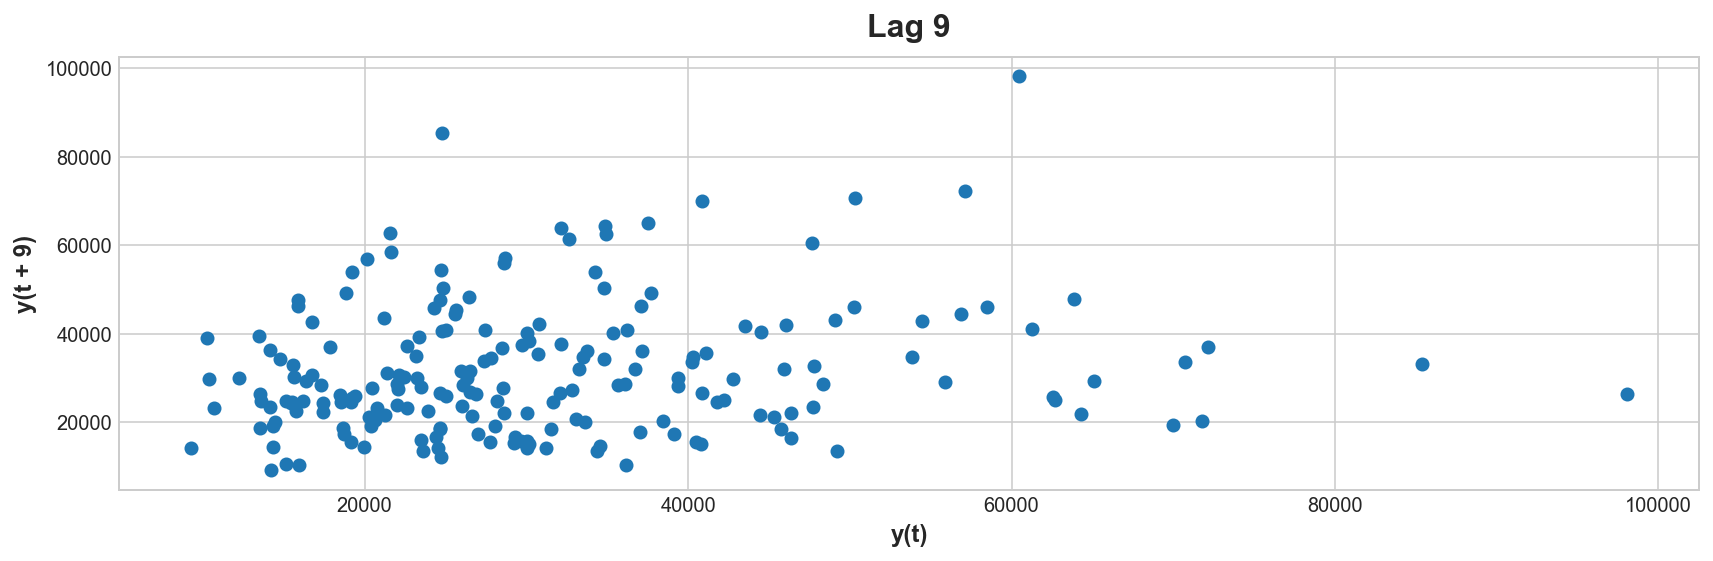

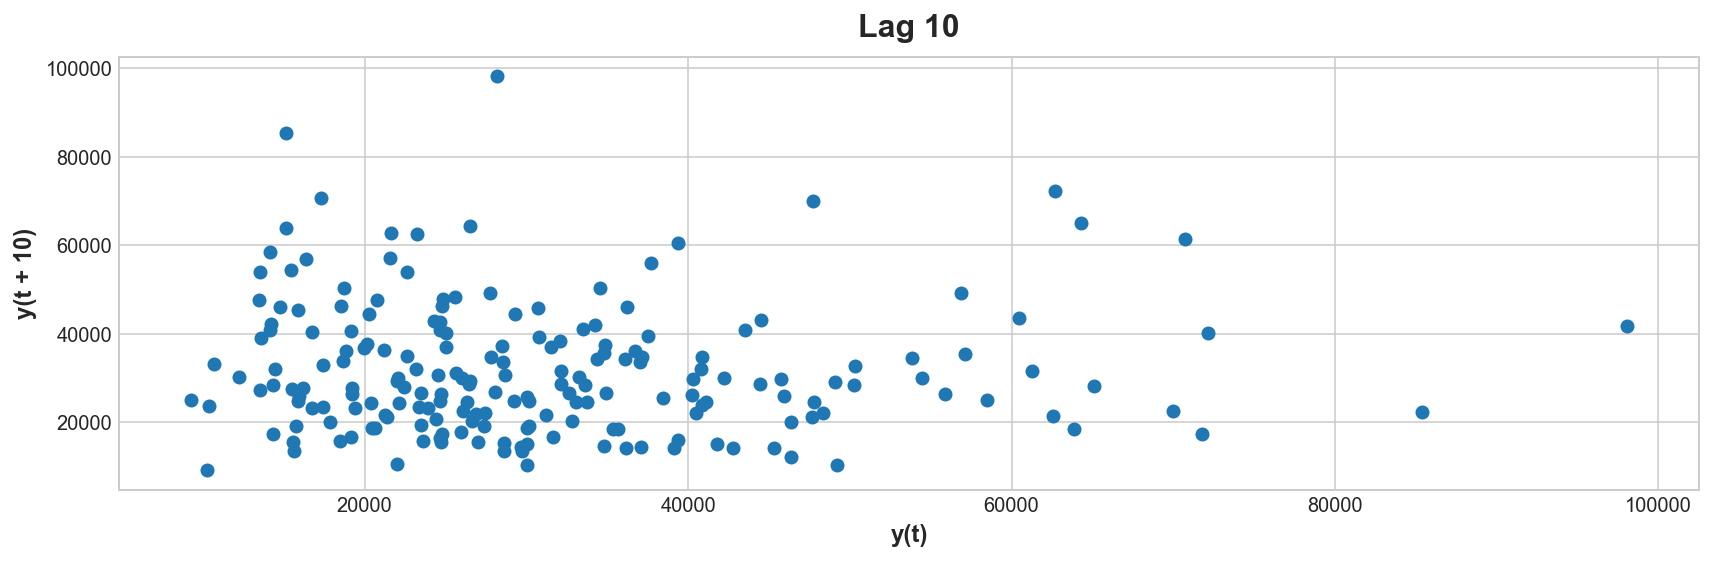

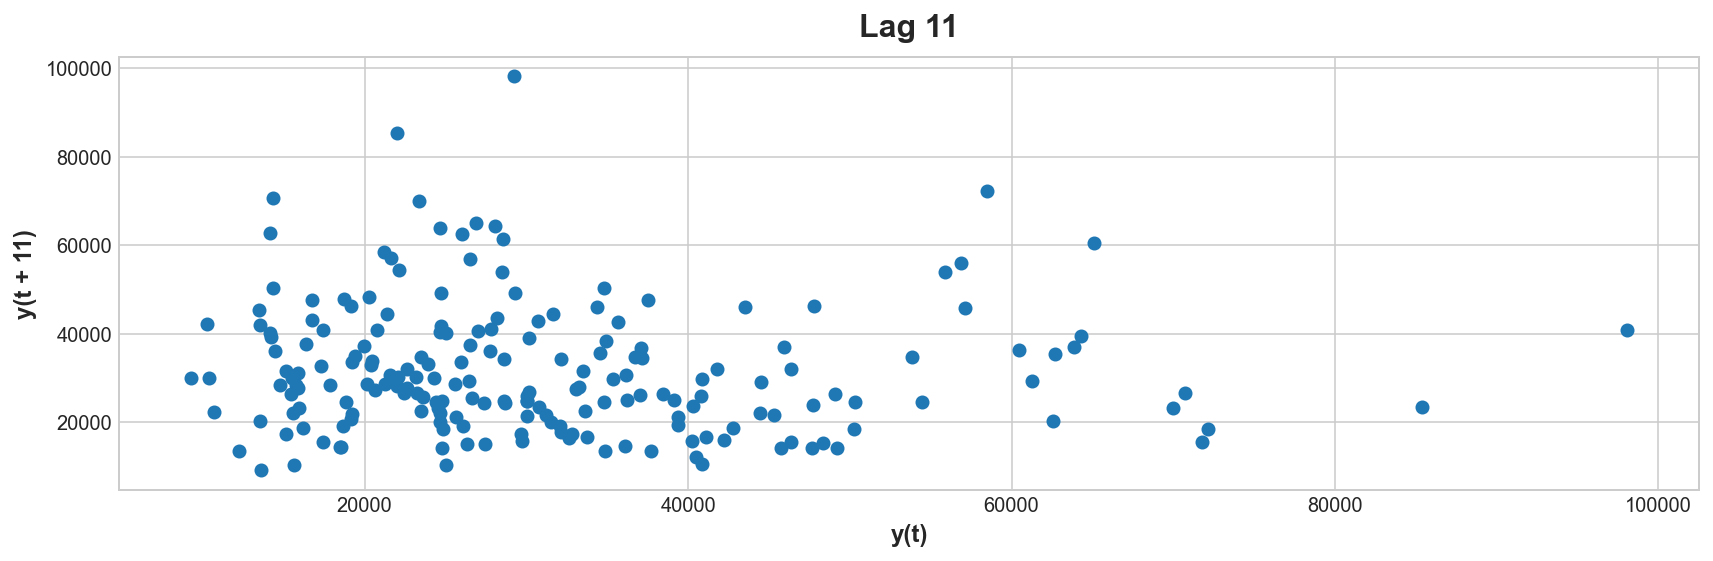

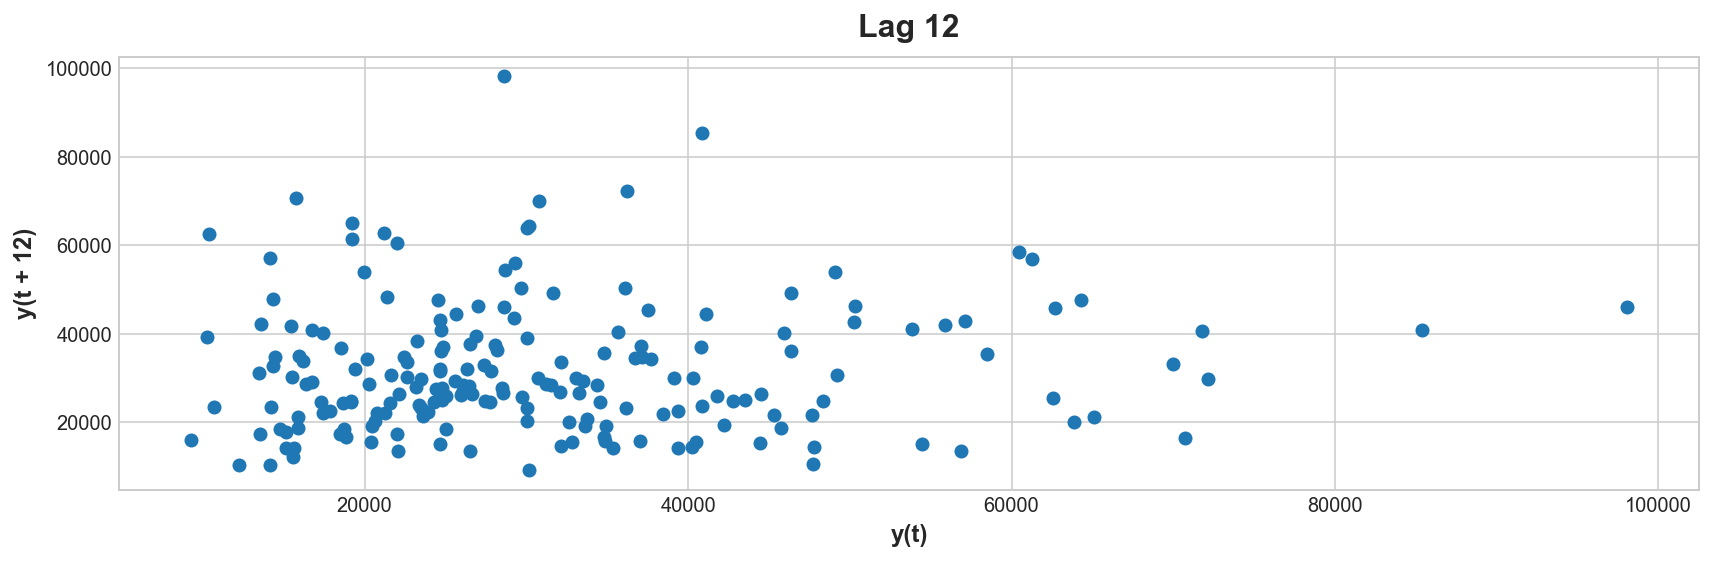

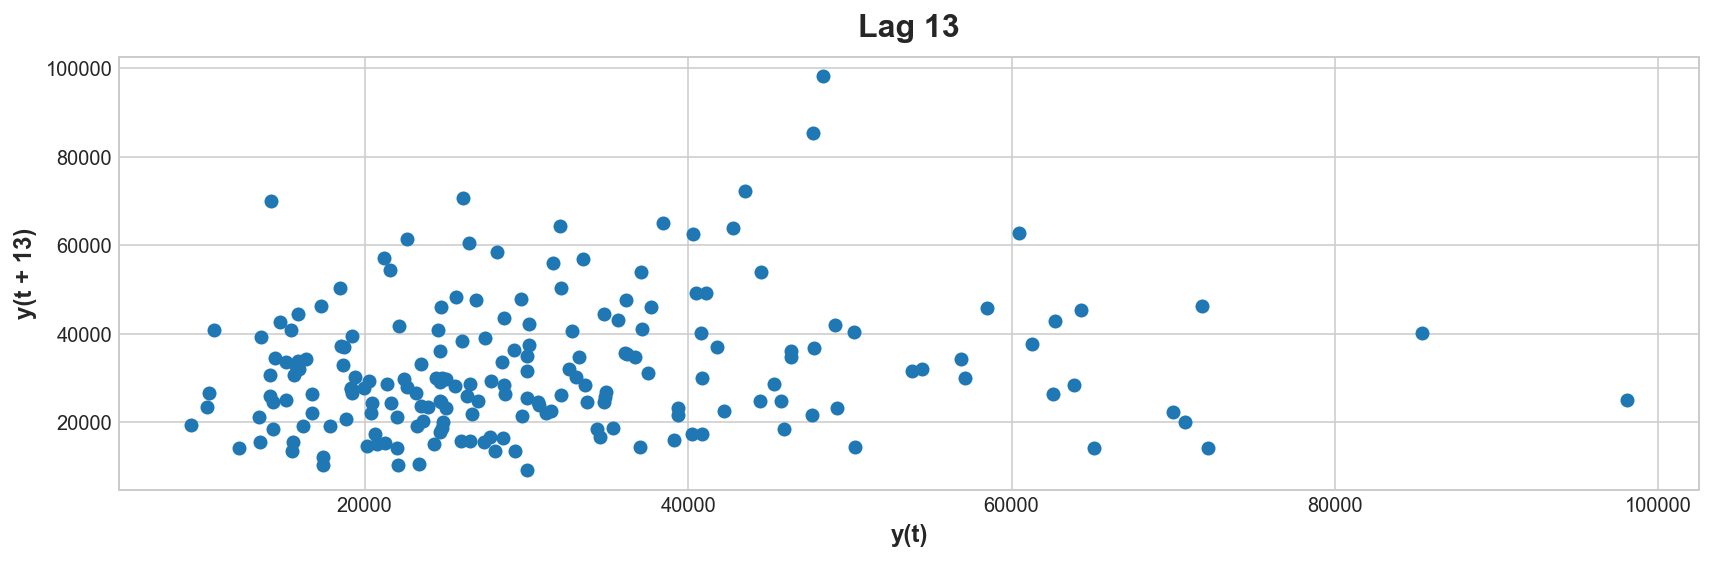

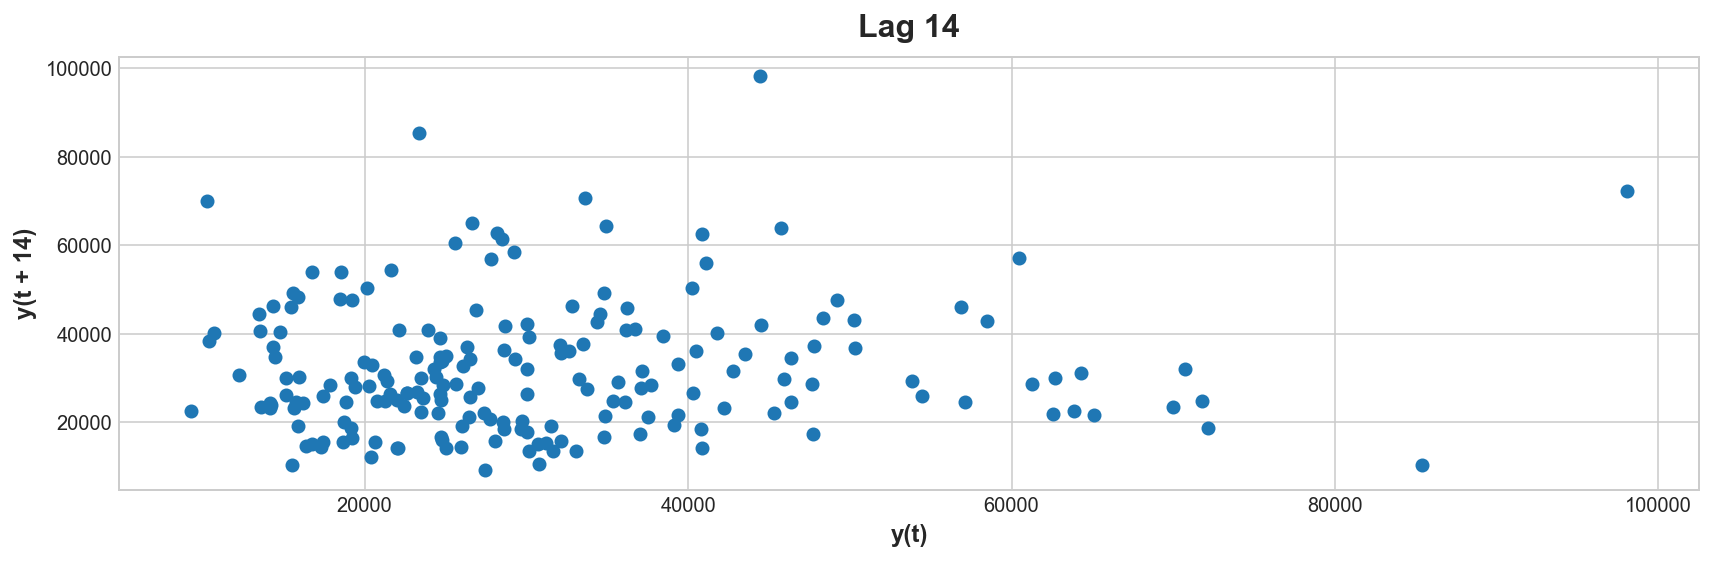

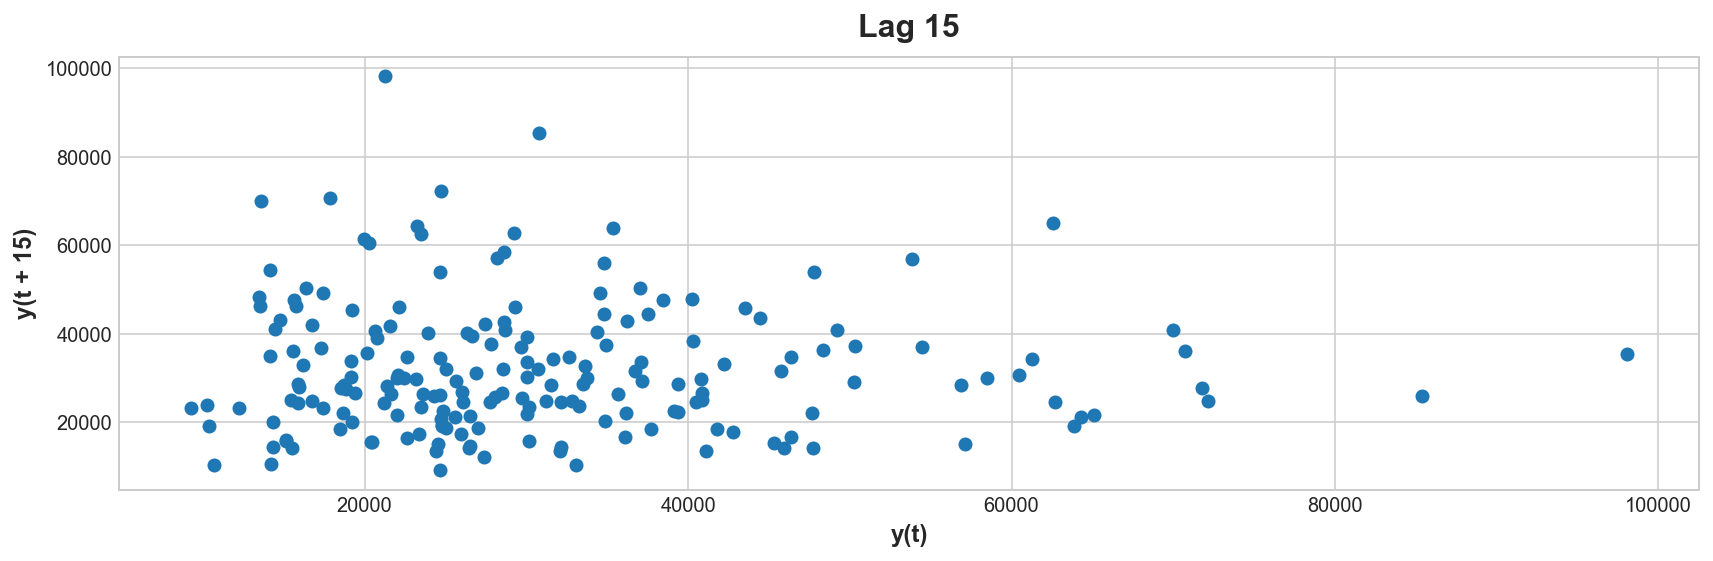

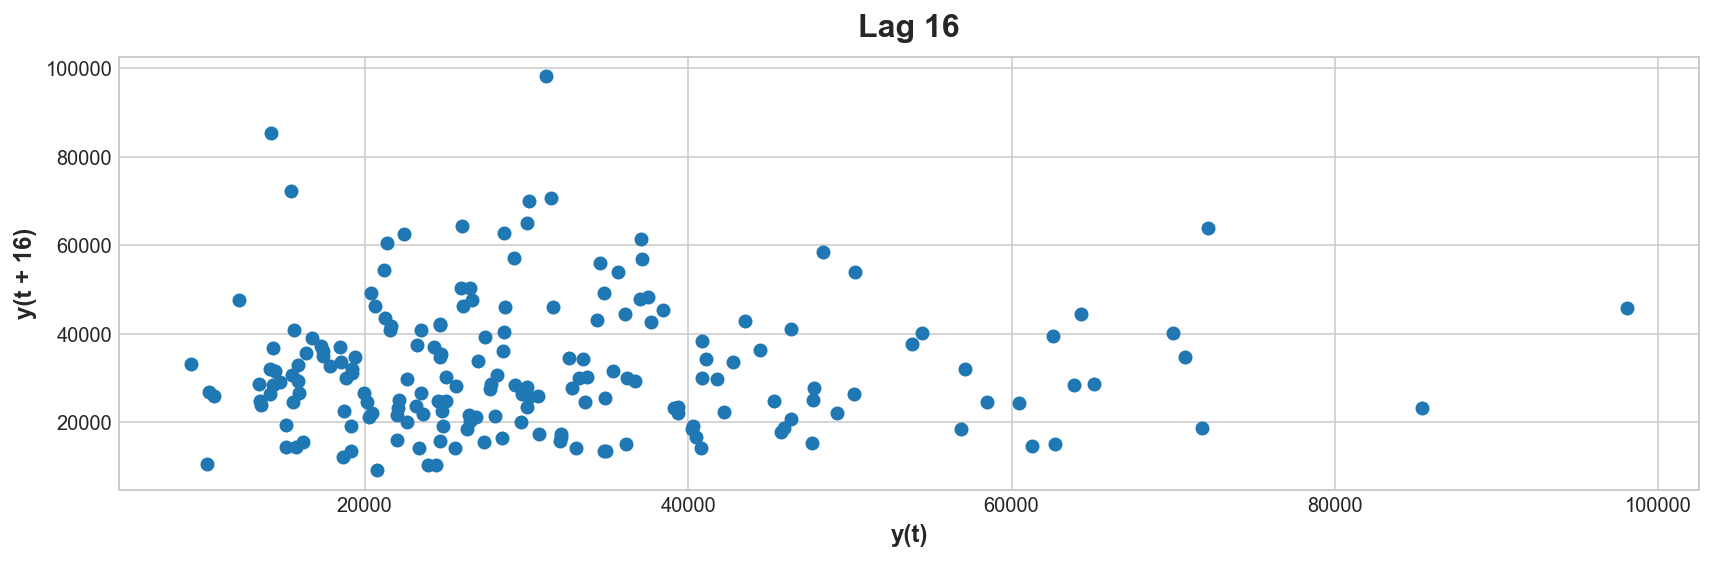

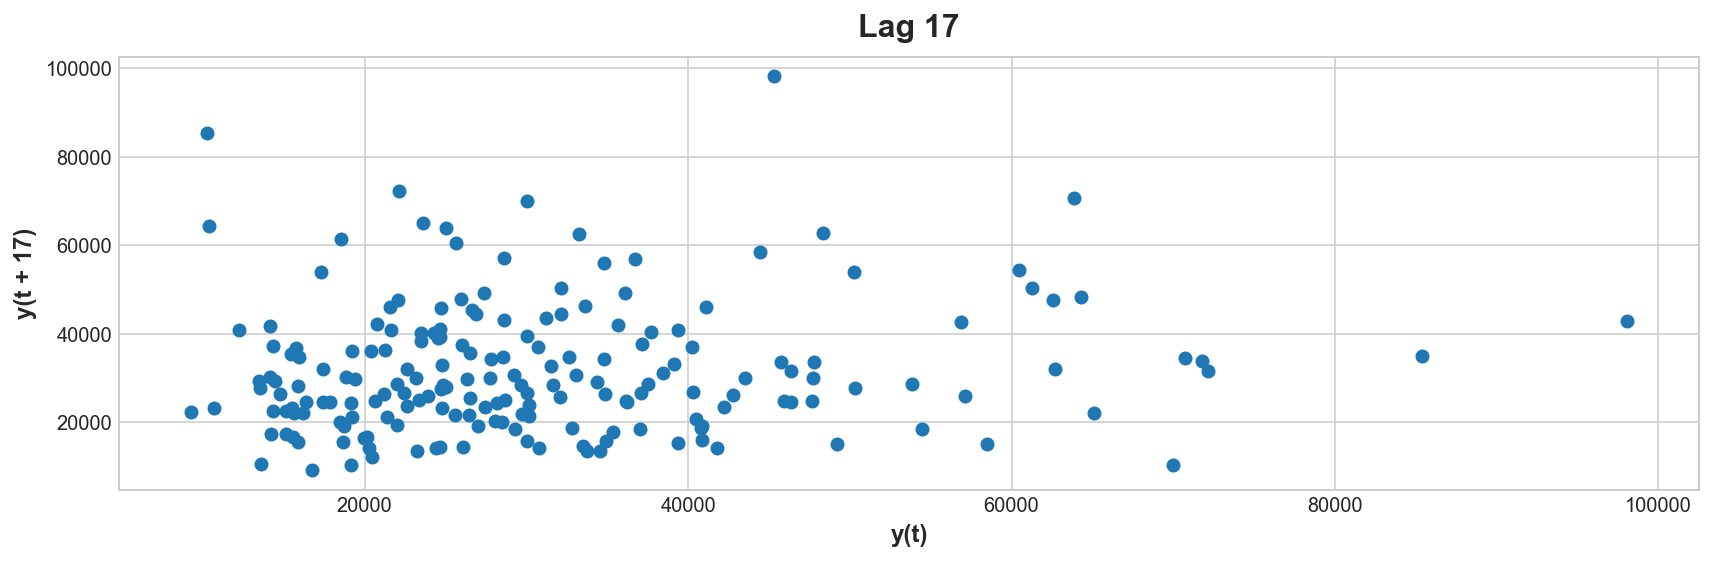

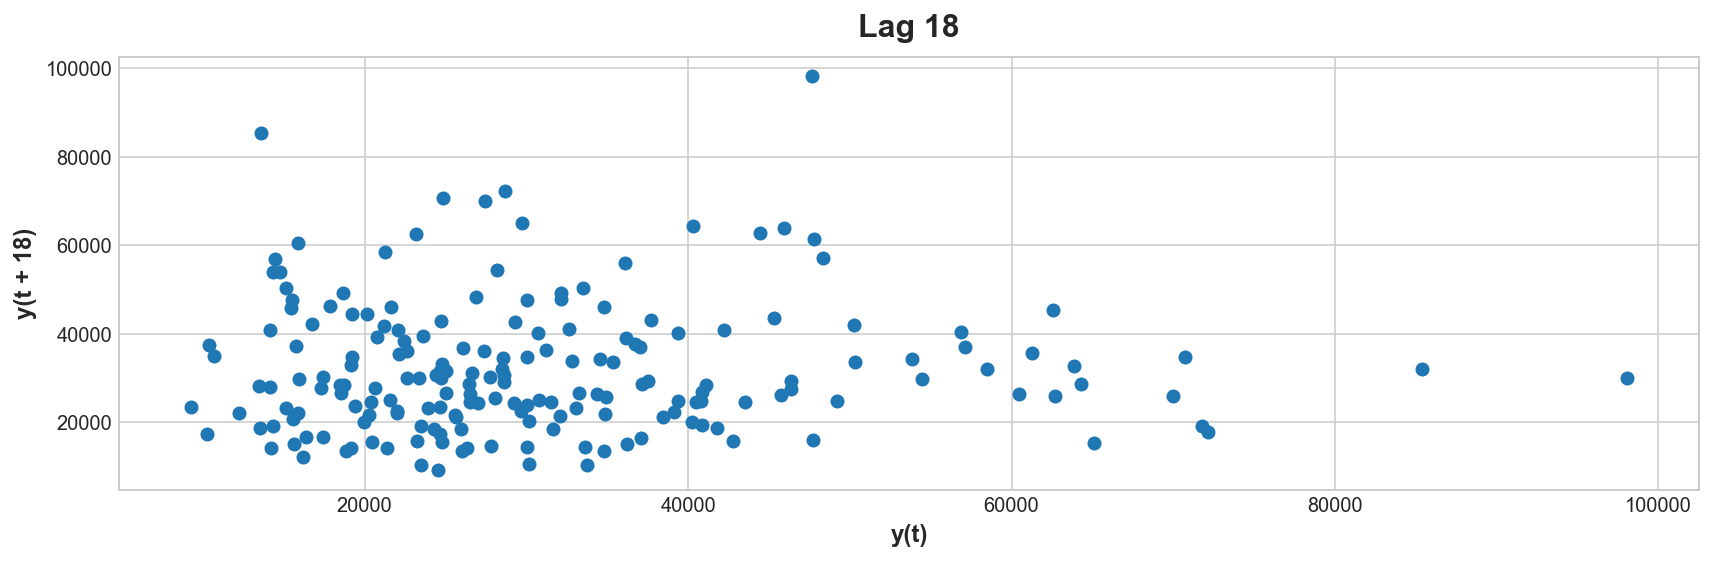

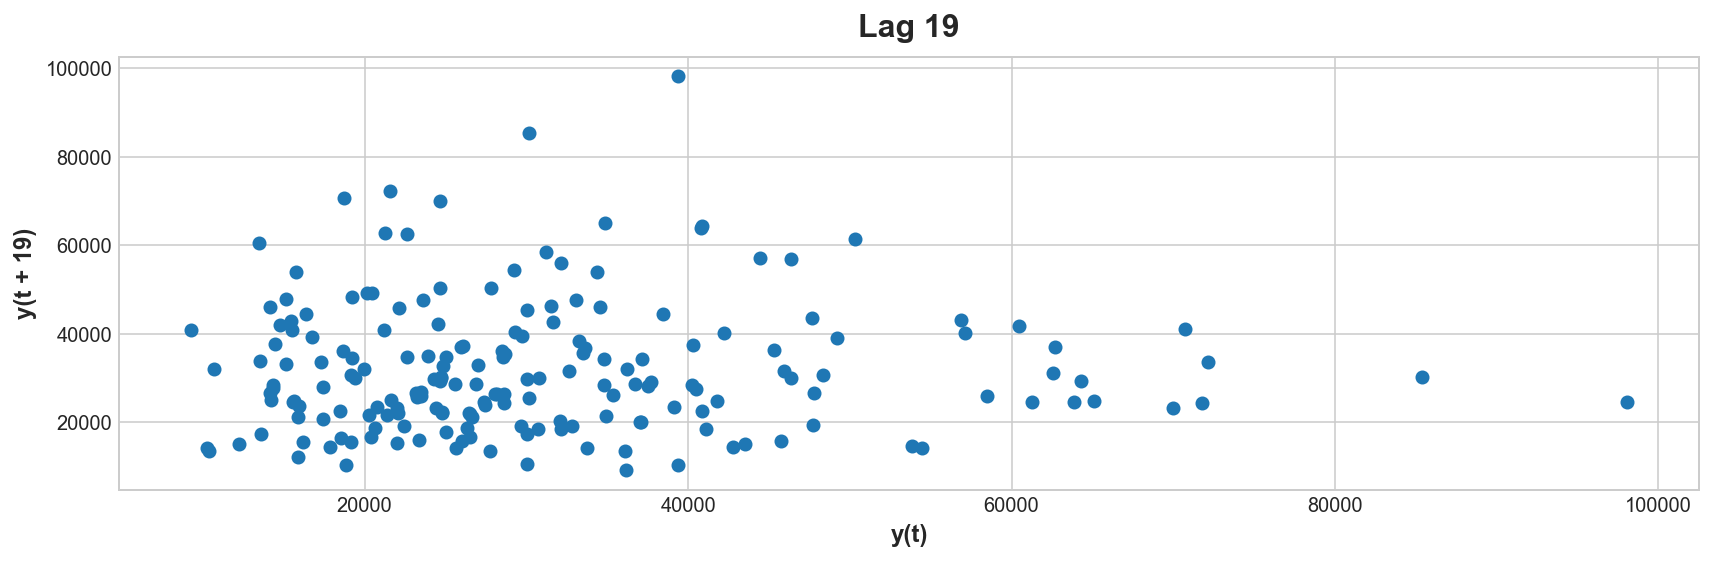

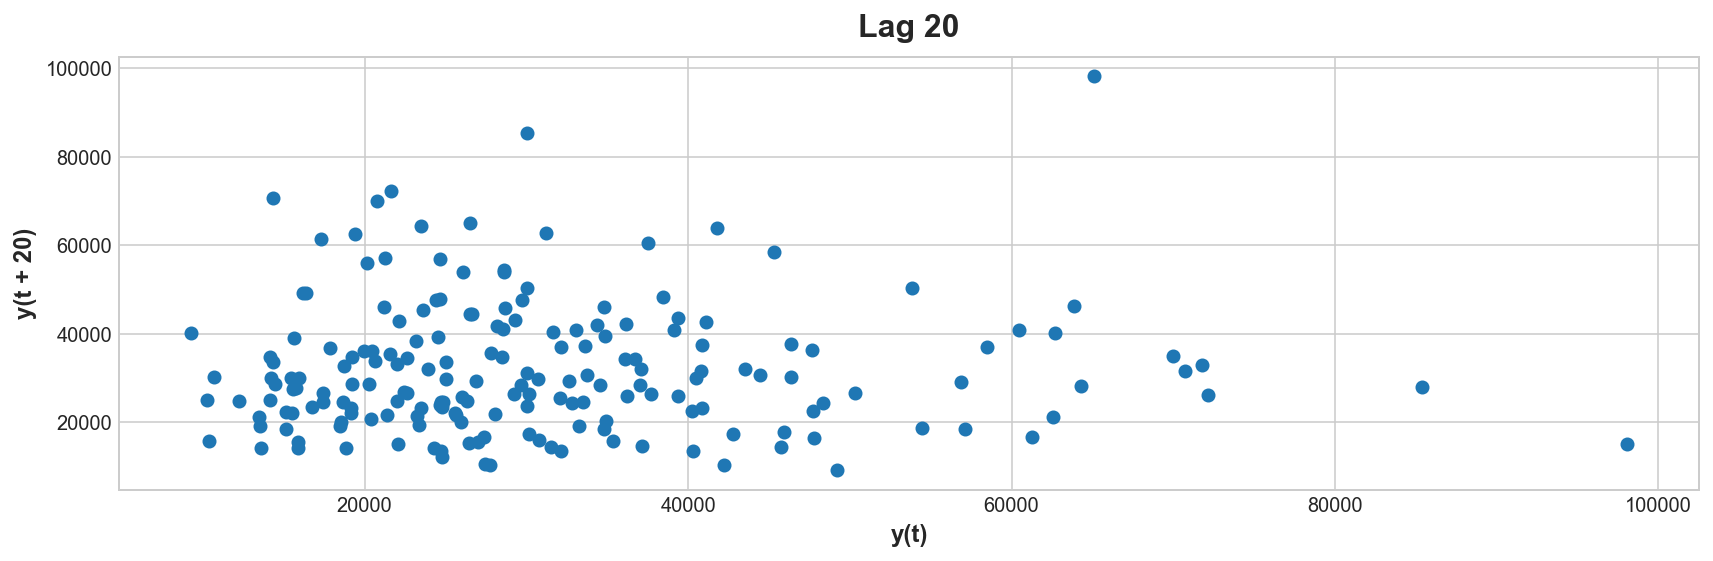

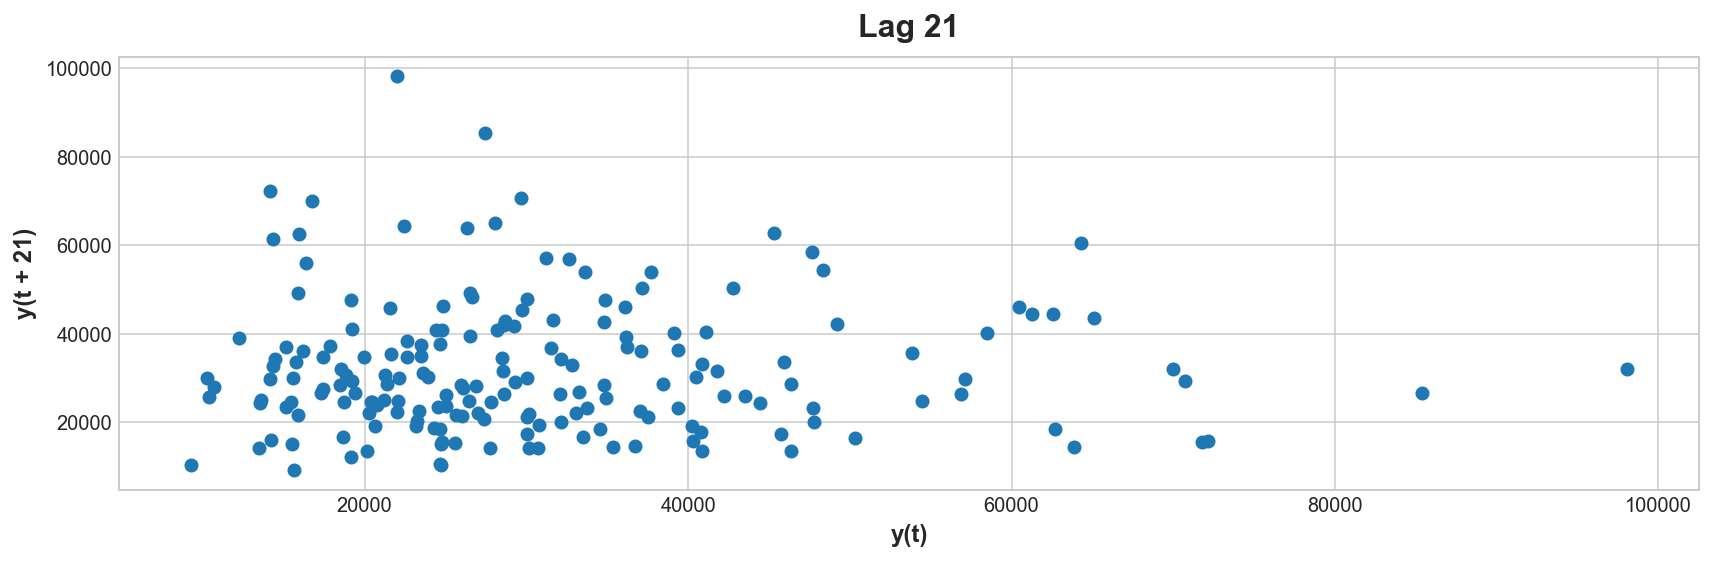

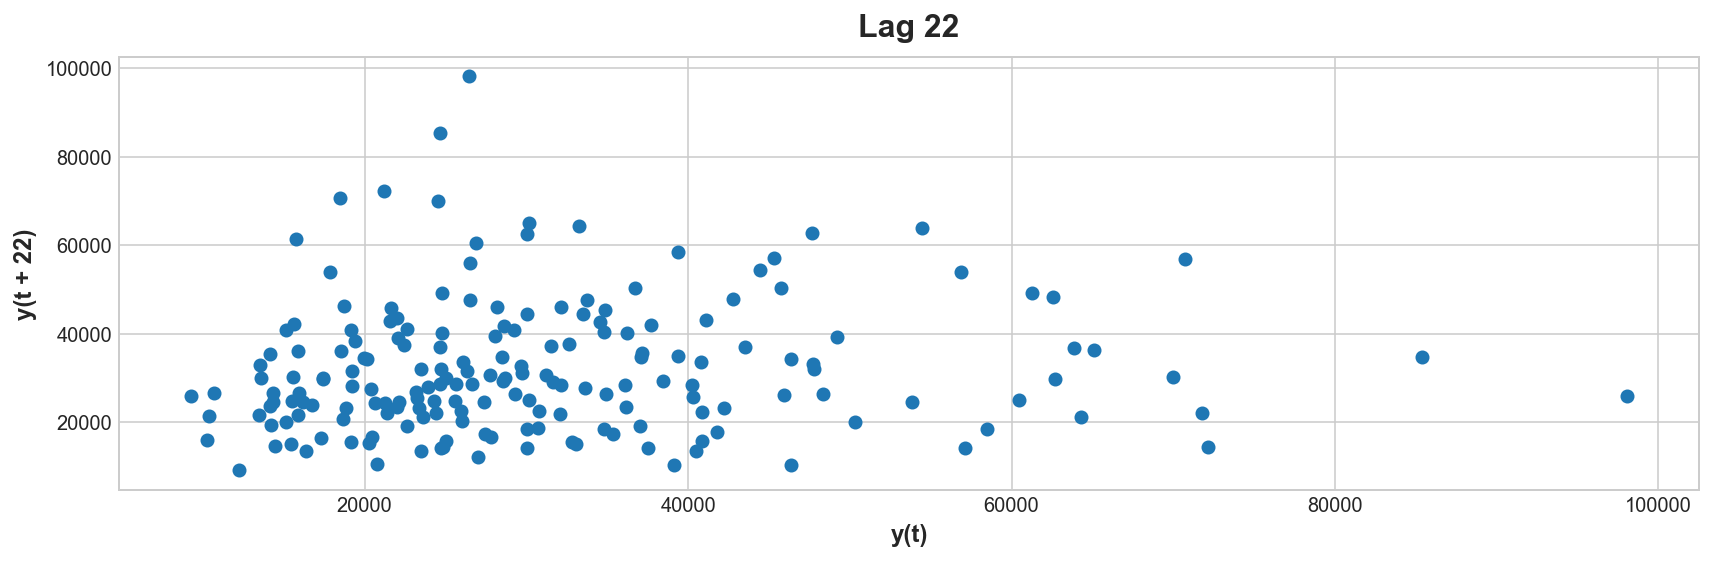

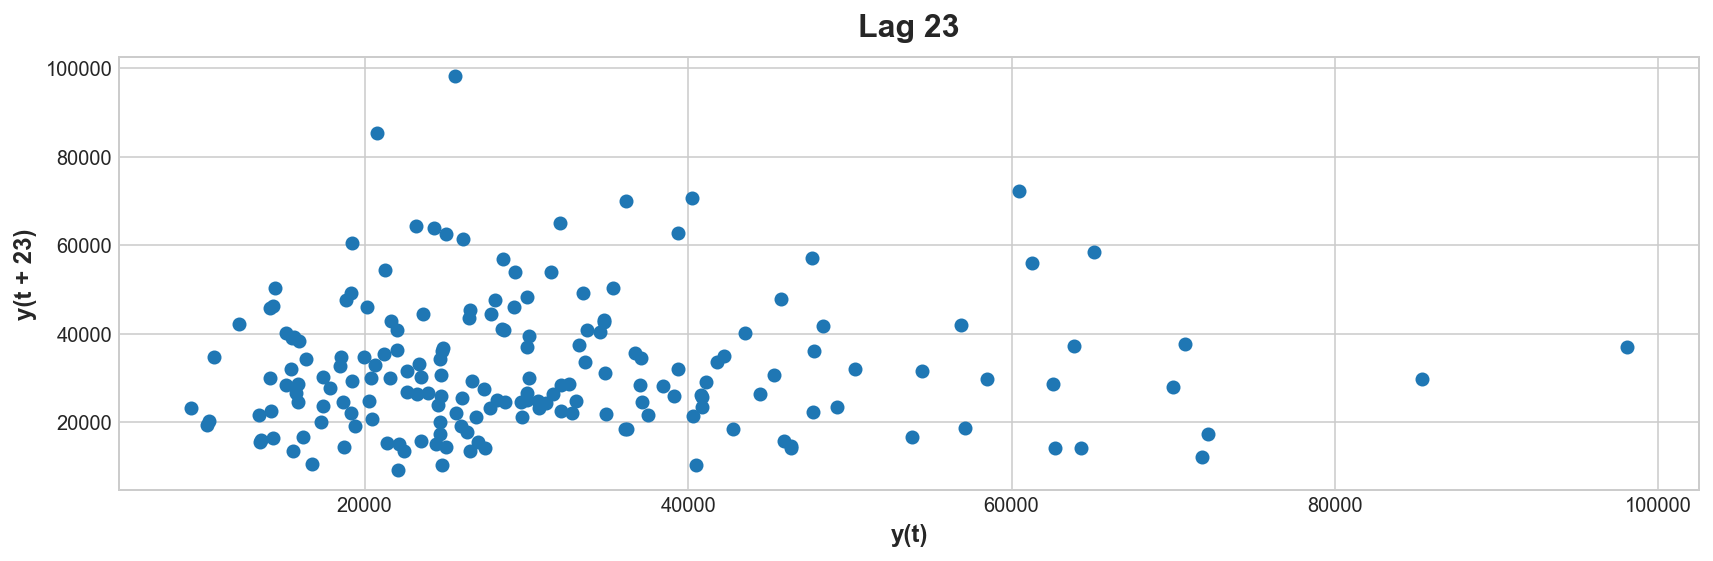

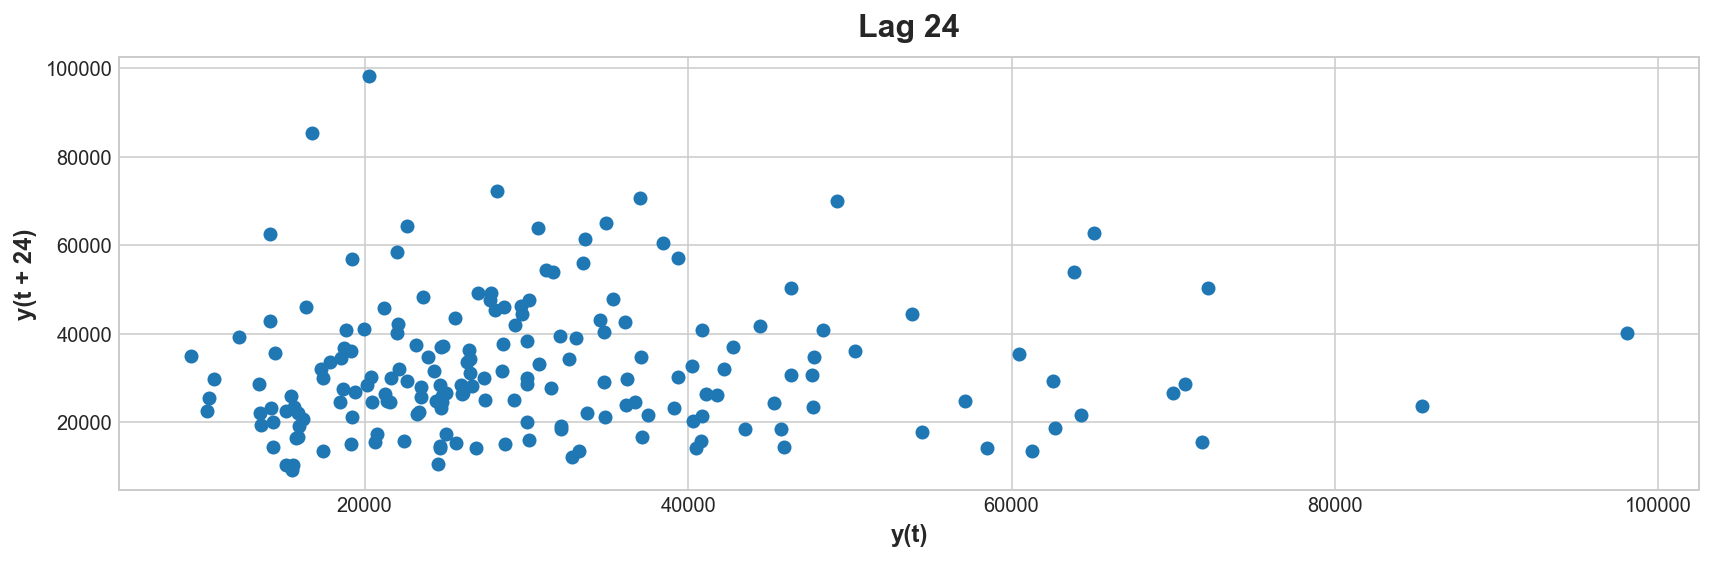

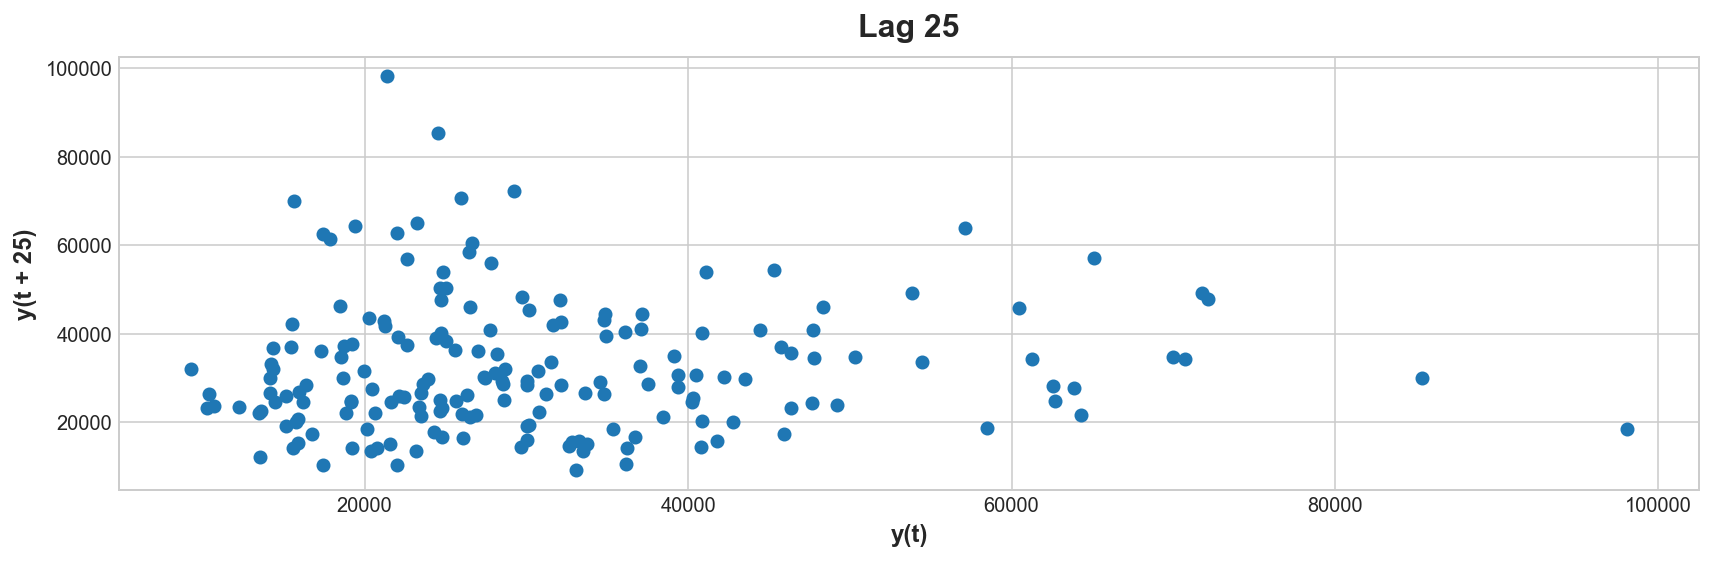

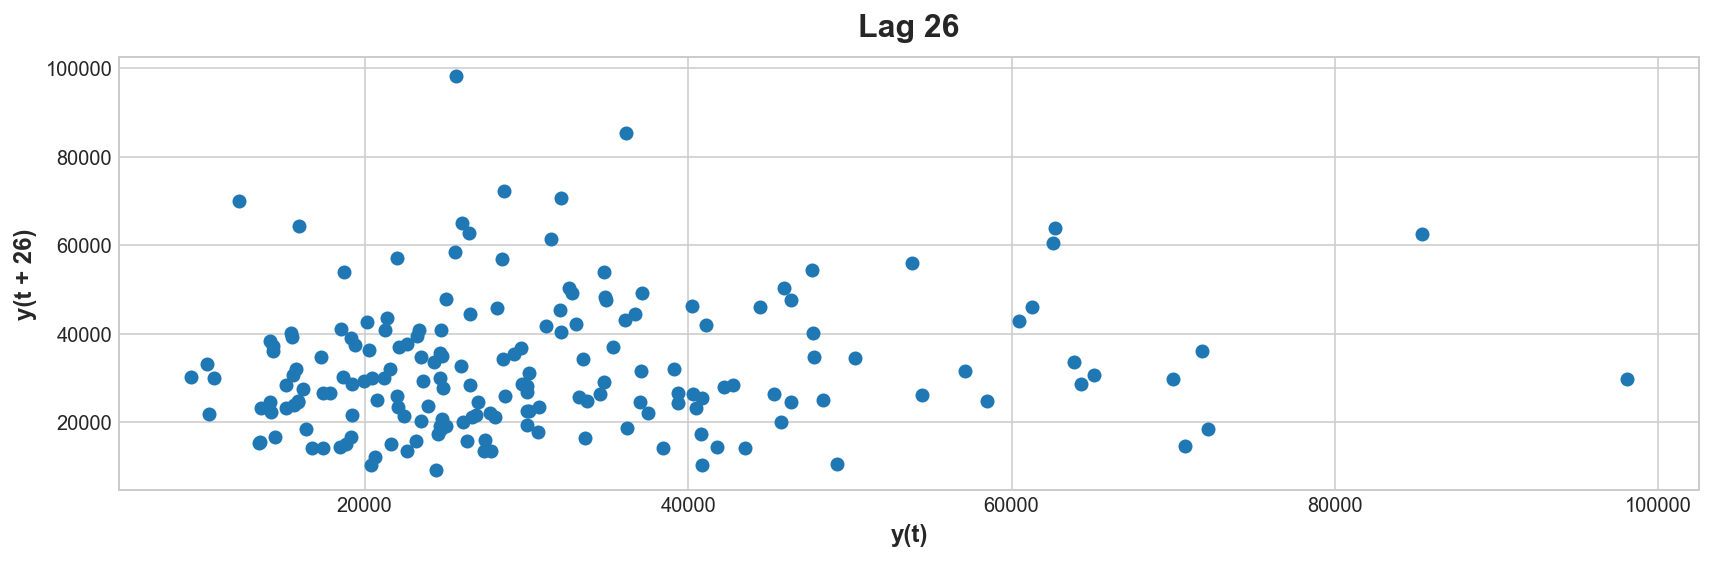

In [62]:
# Lets check weekly lags.
for i in range(1, 27):
    pd.plotting.lag_plot(ts.resample('W').mean(), lag=i)
    plt.title('Lag ' + str(i))
    plt.show()

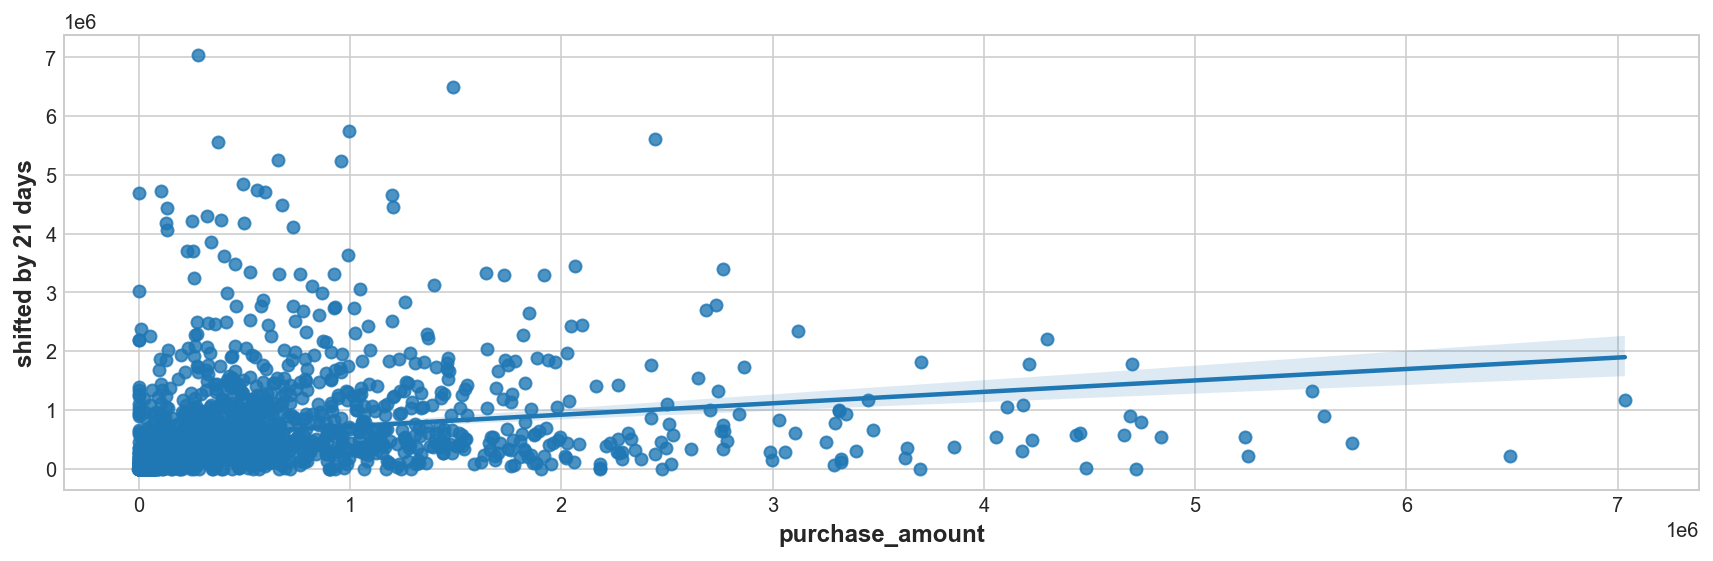

In [63]:
# lag 3 seems to be more correlated
ts_df['lag_21'] = ts_df.purchase_amount.shift(21)
ax = sns.regplot(data=ts_df, x='purchase_amount', y='lag_21')
ax.set(xlabel='purchase_amount', ylabel='shifted by 21 days')
plt.show()

In [64]:
stats.pearsonr(ts_df.purchase_amount, ts_df.lag_21.fillna(ts_df.lag_21.mean()))

(0.19467173233501708, 6.193429177978758e-14)

The correlation coeffictient of 3 weeks (21 day) is lower that 28 days

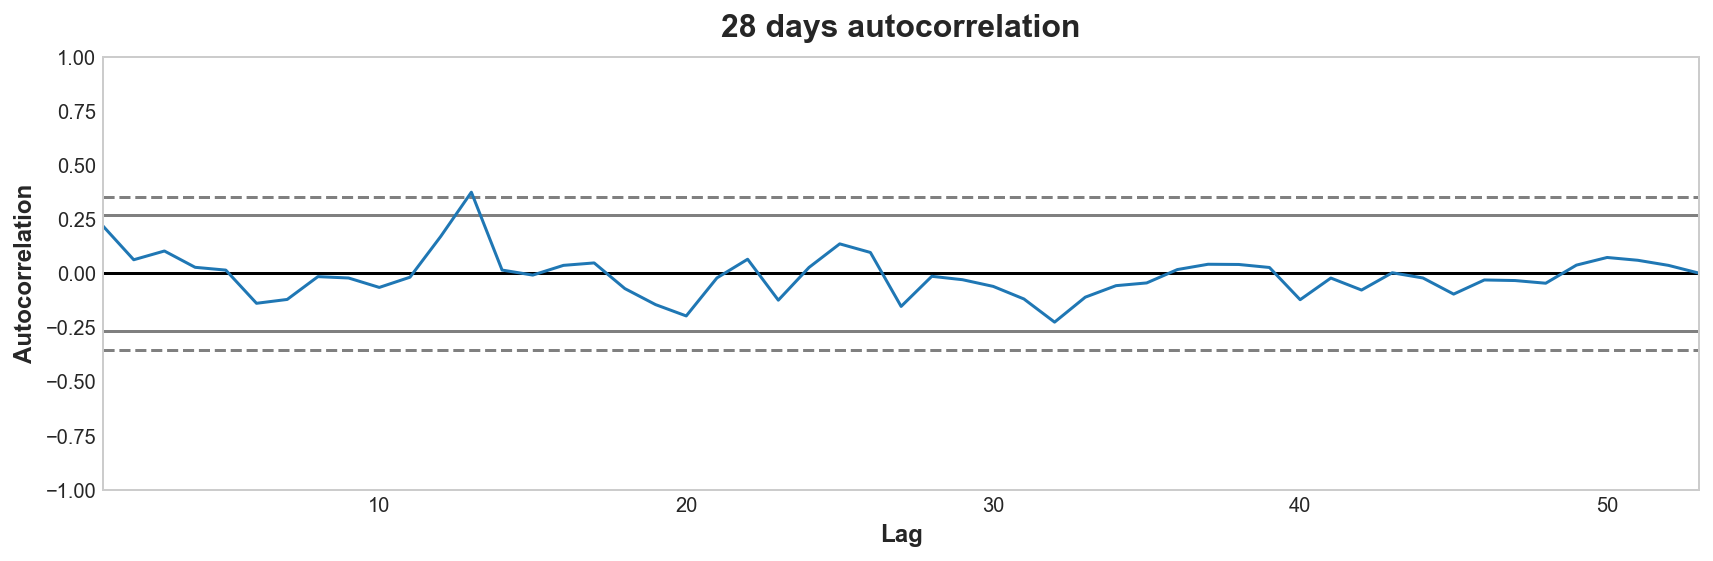

In [65]:
# daily
pd.plotting.autocorrelation_plot(ts.resample('28D').sum())
plt.title('28 days autocorrelation');

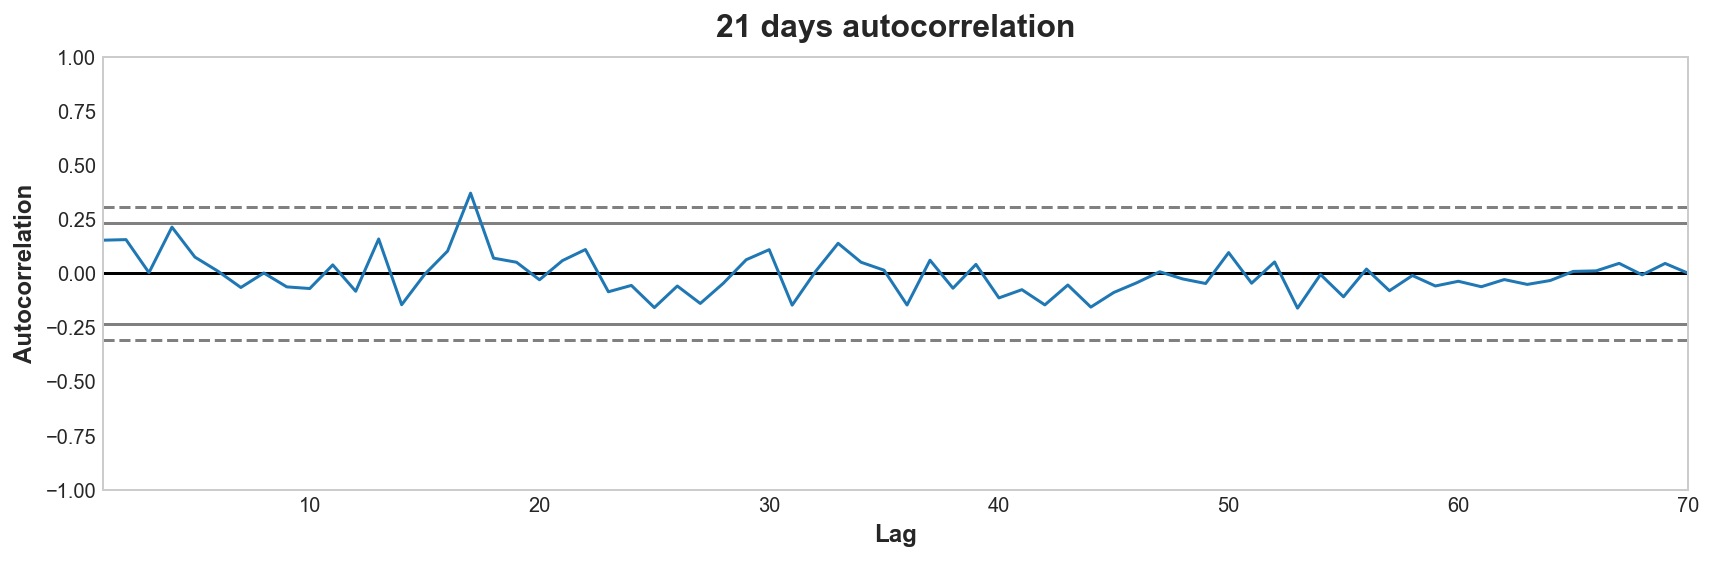

In [66]:
# daily
pd.plotting.autocorrelation_plot(ts.resample('21D').sum())
plt.title('21 days autocorrelation');

## Decomposition. Data = Seasonality + Trend + Residual (noise)

#### Daily

In [67]:
#y_daily = ts.resample('D').sum()
result_d = sm.tsa.seasonal_decompose(y_daily)
decomposition_d = pd.DataFrame({
    'y': result_d.observed,
    'trend': result_d.trend,
    'seasonal': result_d.seasonal,
    'resid': result_d.resid,
})
decomposition_d.head()


y      trend    seasonal      resid
order_date                                               
2018-01-02   171,192.78        NaN  211,671.87        NaN
2018-01-03   102,080.14        NaN  221,683.31        NaN
2018-01-04   181,355.01        NaN  274,176.81        NaN
2018-01-05 1,029,700.32 243,062.57  301,459.00 485,178.74
2018-01-06    41,740.42 244,356.98 -602,414.87 399,798.31

<AxesSubplot: xlabel='order_date'>

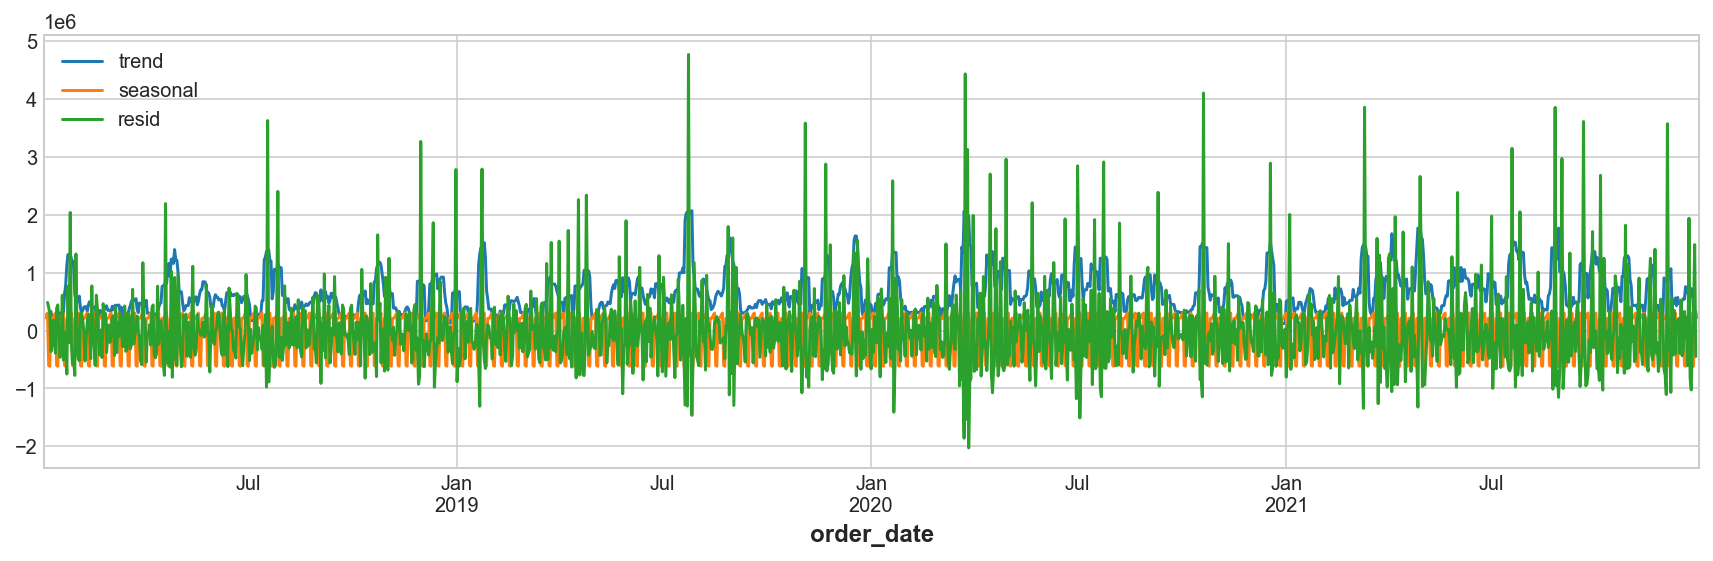

In [68]:
# plot everything but y_daily
decomposition_d.iloc[:, 1:].plot()

#### Weekly

<AxesSubplot: xlabel='order_date'>

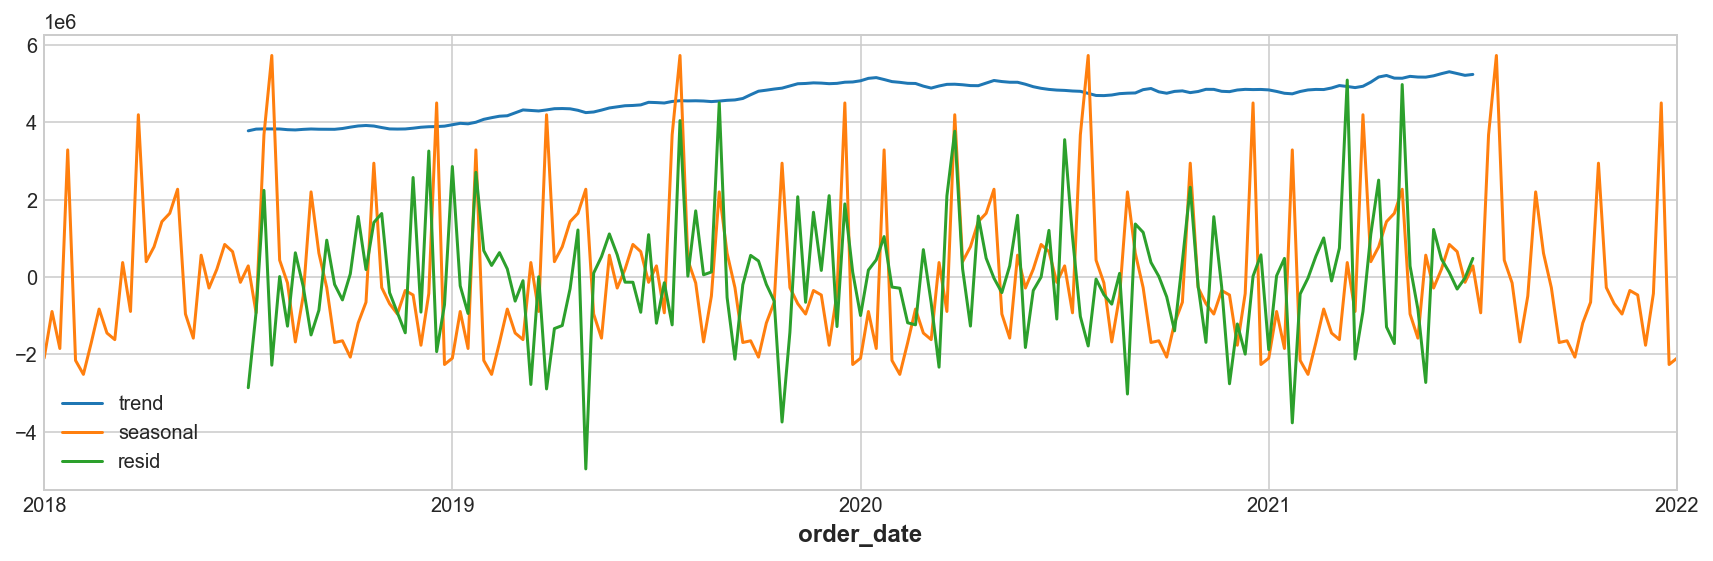

In [69]:
y_weekly = ts.resample('W').sum()
result_w = sm.tsa.seasonal_decompose(y_weekly)
decomposition_w = pd.DataFrame({
    'y': result_w.observed,
    'trend': result_w.trend,
    'seasonal': result_w.seasonal,
    'resid': result_w.resid,
})
decomposition_w.iloc[:, 1:].plot()

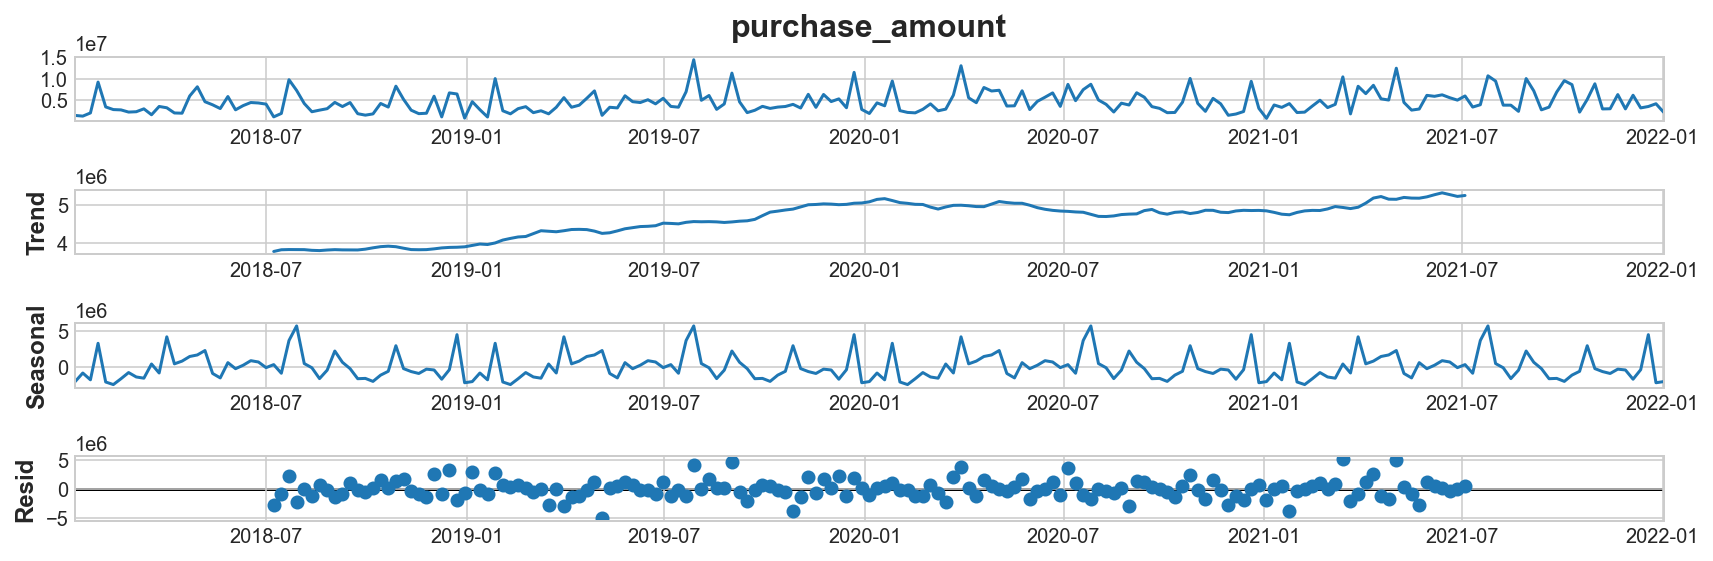

In [70]:
result_w.plot()
None # to make 1 graph only

We can observe some little trend in weekly decomposition

#### Monthly

<AxesSubplot: xlabel='order_date'>

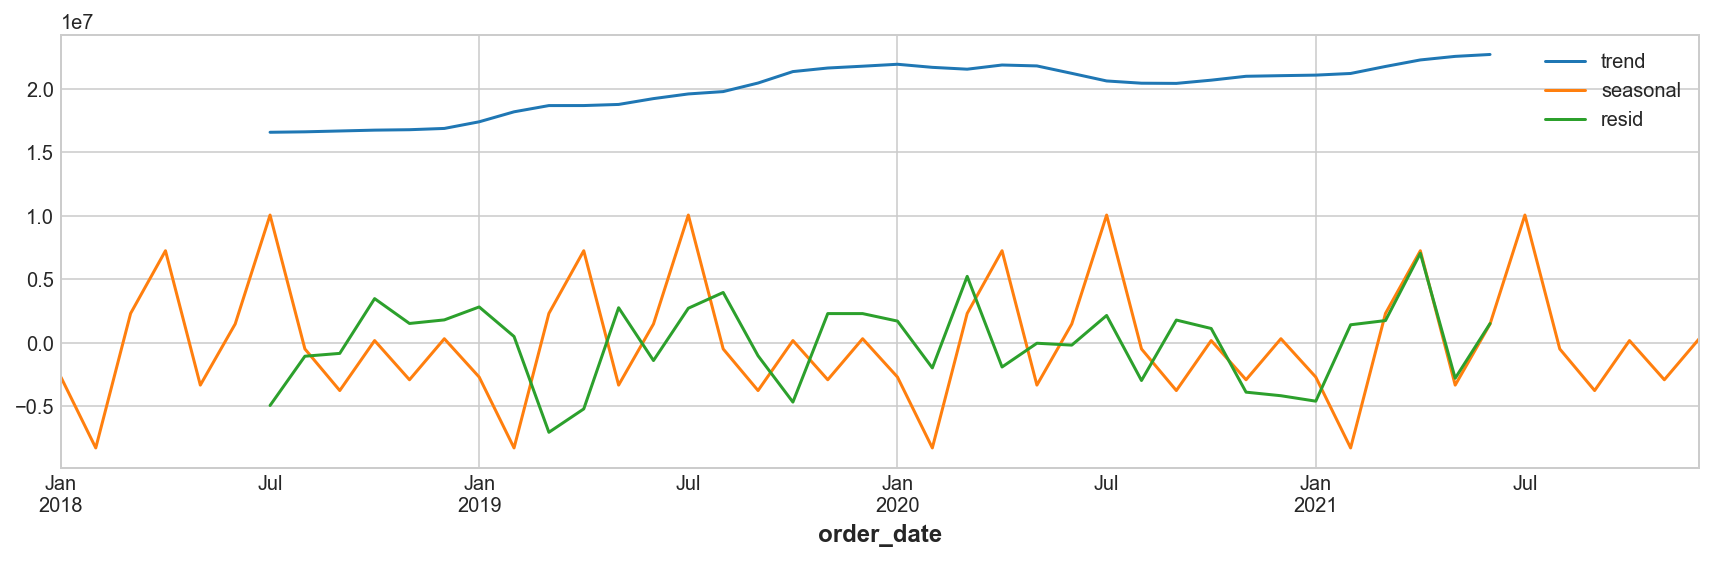

In [71]:
y_monthly = ts.resample('M').sum()
result_m = sm.tsa.seasonal_decompose(y_monthly)
decomposition_m = pd.DataFrame({
    'y': result_m.observed,
    'trend': result_m.trend,
    'seasonal': result_m.seasonal,
    'resid': result_m.resid,
})
decomposition_m.iloc[:, 1:].plot()

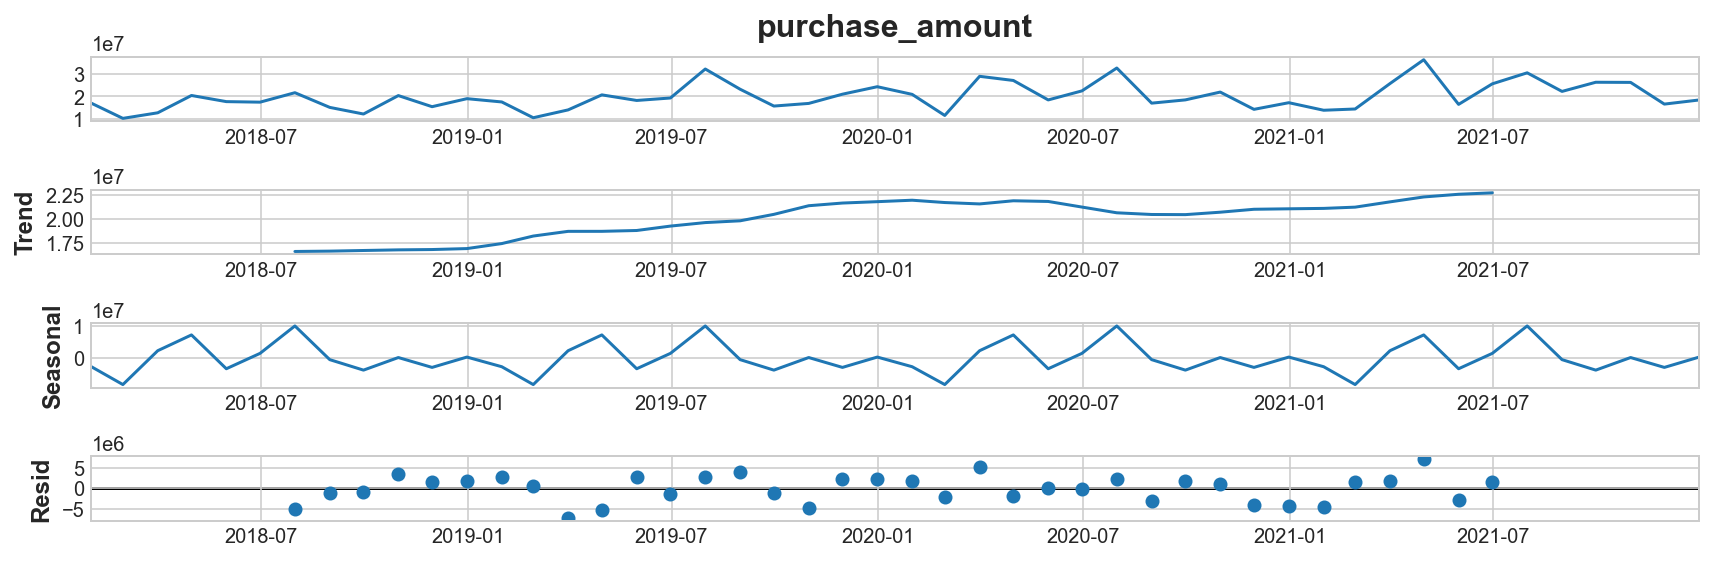

In [72]:
result_m.plot()
None

In [73]:
decomposition_m['time_dummy'] = np.arange(len(decomposition_m.index))

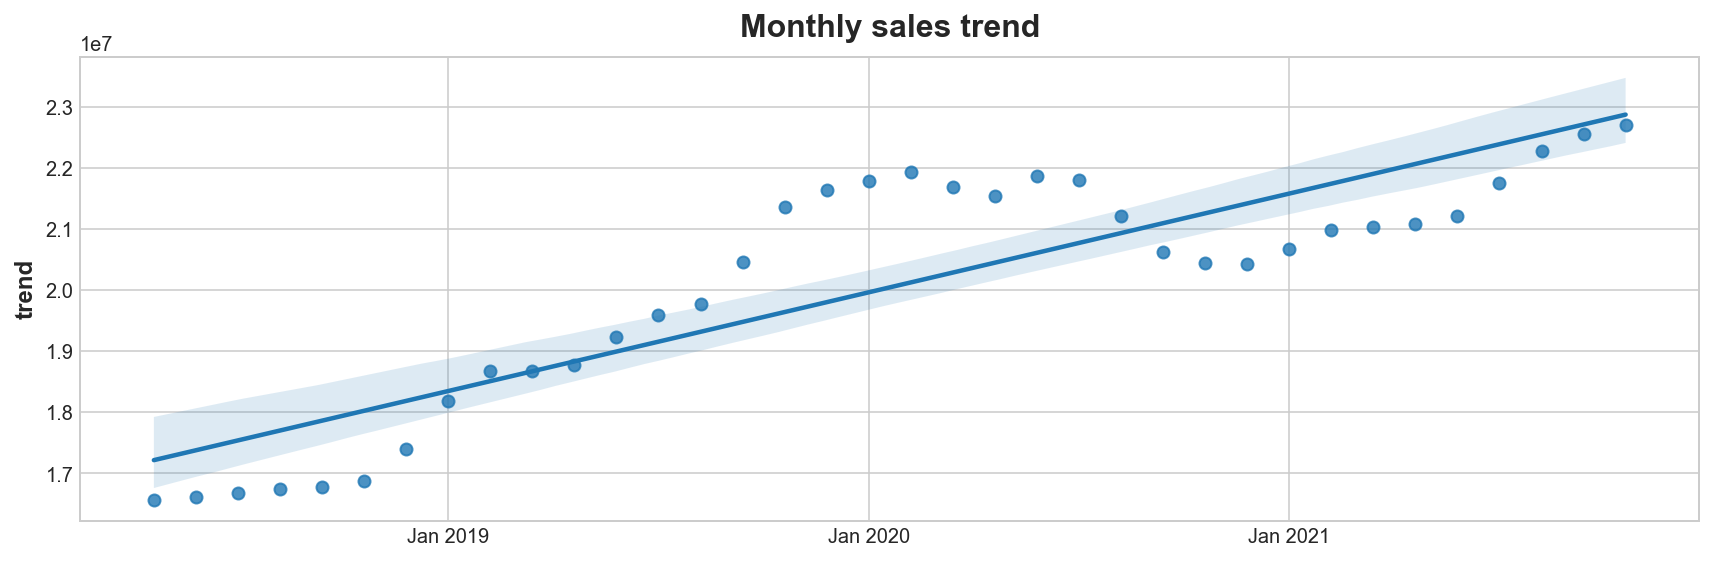

In [74]:
ax = sns.regplot(y=decomposition_m.trend, x=decomposition_m.time_dummy)
plt.title('Monthly sales trend')
plt.xlabel(None)
ax.set(xticks=[13, 23, 33])
ax.set(xticklabels=['Jan 2019', 'Jan 2020', 'Jan 2021'])
plt.show()

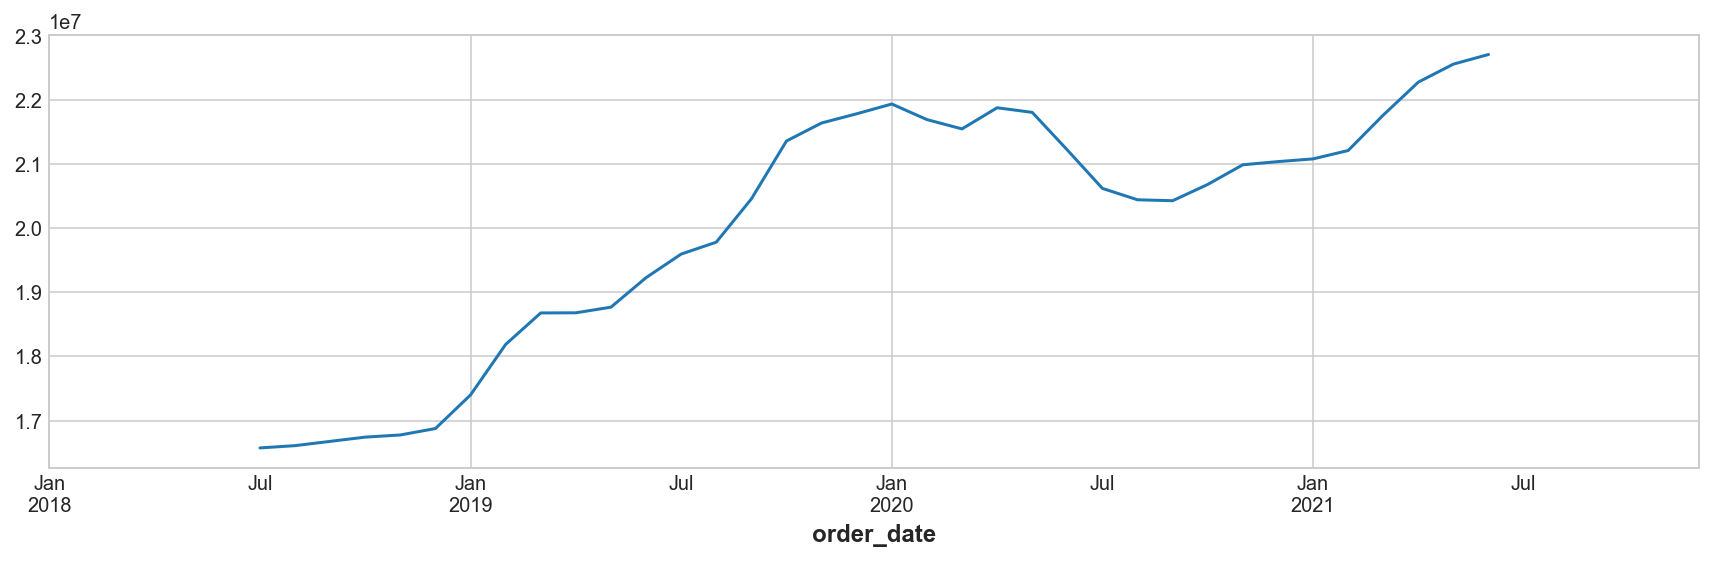

In [75]:
decomposition_m.trend.plot()
plt.show()

#### Takeaway:
We can see the trend in monthly sales

#### Quarterly decomposition

<AxesSubplot: xlabel='order_date'>

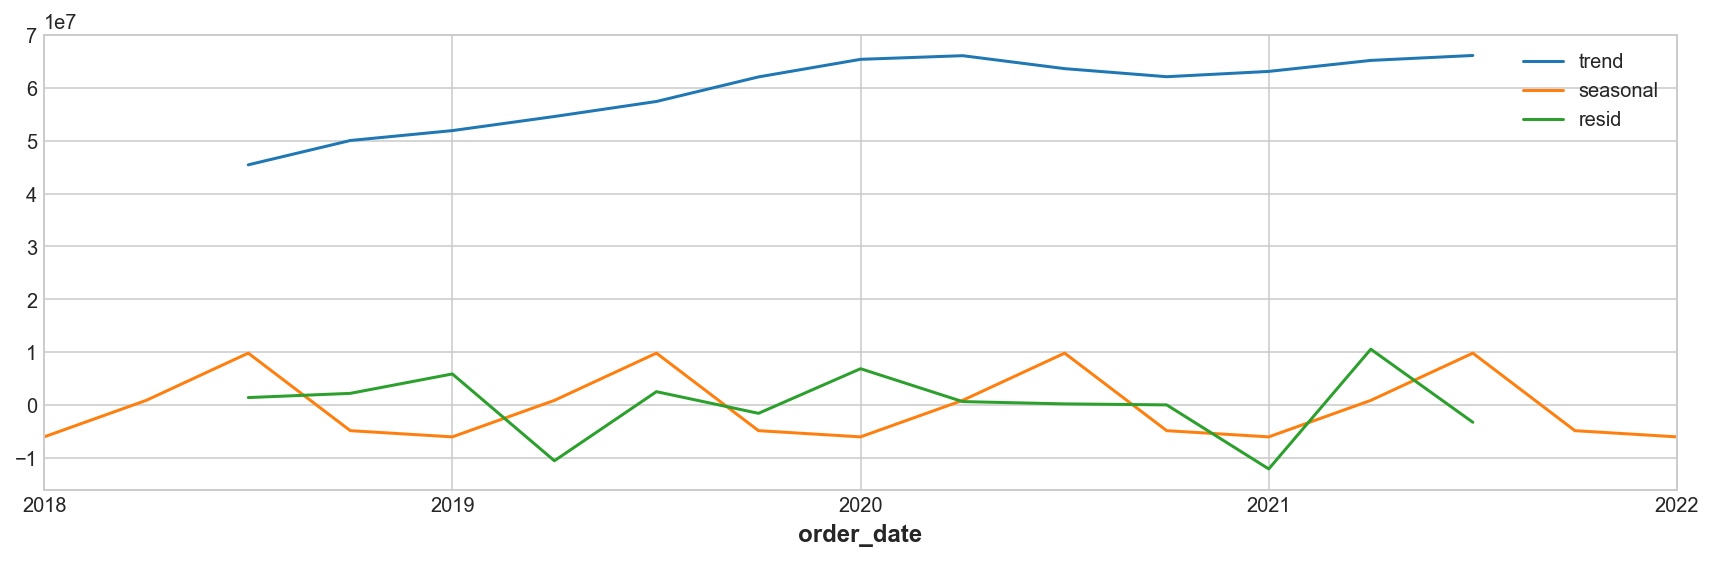

In [76]:
y_quarterly = ts.resample('3M').sum()
result_q = sm.tsa.seasonal_decompose(y_quarterly)
decomposition_q = pd.DataFrame({
    'y': result_q.observed,
    'trend': result_q.trend,
    'seasonal': result_q.seasonal,
    'resid': result_q.resid,
})
decomposition_q.iloc[:, 1:].plot()

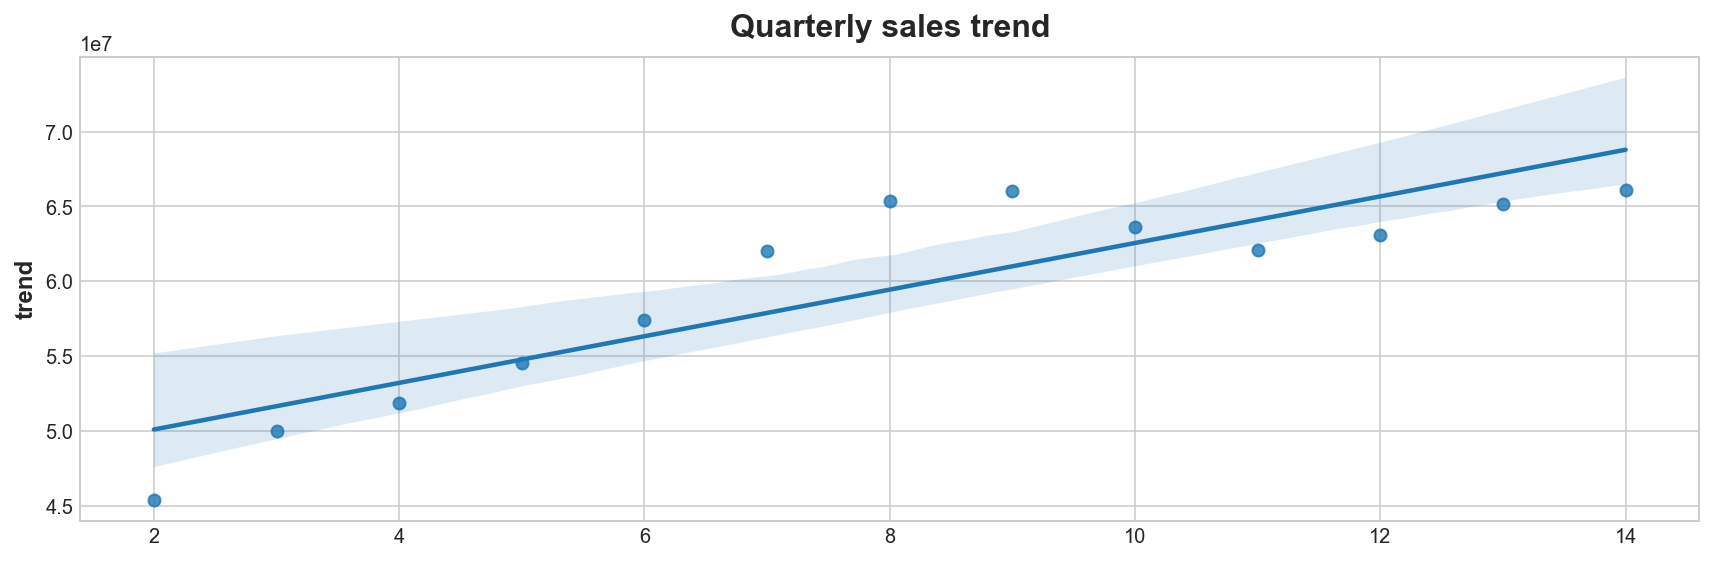

In [77]:
decomposition_q['time_dummy'] = np.arange(len(decomposition_q.index))
ax = sns.regplot(y=decomposition_q.trend, x=decomposition_q.time_dummy)
plt.title('Quarterly sales trend')
plt.xlabel(None)
#ax.set(xticks=[13, 23, 33])
#ax.set(xticklabels=['Jan 2019', 'Jan 2020', 'Jan 2021'])
plt.show()

In [88]:
y_daily[y_daily < 0]

order_date
2018-04-01   -5,149.00
Freq: D, Name: purchase_amount, dtype: float64

In [84]:
y_weekly[y_weekly <=0]

Series([], Freq: W-SUN, Name: purchase_amount, dtype: float64)

#### There are 257 days when the total sales are equal to 0, 1 day when total sales are negative. All weekly totals are positive

In [96]:
sdf.loc[['2018-04-01']]

customer_name     customer_type customer_city  \
order_date                                                        
2018-04-01  City of San Antonio  Local Government   San Antonio   

                                                reseller_name shipped_date  \
order_date                                                                   
2018-04-01  Great South Texas Corporation dba Computer Sol...   2018-04-18   

            purchase_amount  
order_date                   
2018-04-01        -5,149.00